# <center> <b>  Νευρώνικα Δίκτυα-Βαθία Μάθηση </b> </center>
## <center> <b>2η ΥΠΟΧΡΕΩΤΙΚΗ ΕΡΓΑΣΙΑ</b> </center>
### <center> <b>  Θεολόγης Γεώργιος </b>  , ΑΕΜ:10413 </center>

### <center> email: gtheolog@ece.auth.gr </center>

### <center> Τμήμα Ηλεκτρολόγων Μηχανικών και Μηχανικών Υπολογιστών </center>

Στη παρούσα εργασία έγινε η υλοποιήση <u> <b> Support Vector Machine</b></u> (Classification) που εκπεδευεταί πάνω σε δεδομένα της Cifar-10.

Κατά την εκπόνηση της εργασίας προσπαθήσαμε να λύσουμε τα εξής προβλήματα:
* Binary Classification Problem (SVM) για Airplane(0) και Automobile(1)
* MultiClass Classification Problem (SVM) για όλη την Cifar-10 με προσέγγιση OnevsOne (1v1).

Έχουνε χρησιμοποίηθει έτοιμες κλάσεις SVM από την sklearn (cpu) και την cuML (gpu) αλλά έχουμε υλοποίησει και δική μας κλάση my_SVM κυρίως για εκπαιδευτικούς σκοπούς και για να συγκρινούμε την λειτουργία της με τις έτοιμες κλάσεις από τις ξένες βιβλιοθήκες.

### Εισαγωγή απαραίτητων βιβλιοθηκών.

In [667]:
import torch                            #PyTorch για χρήση tensor
import numpy as np                      #numpy για πράξεις με arrays
import pandas as pd
import matplotlib.pyplot as plt         #για εύχρηστα plots
from sklearn.decomposition import PCA   #Principal Component Analysis της sklearn
from sklearn.preprocessing import StandardScaler #Για γρήγορο scaling των δεδομένων της βάσης βοηθάει στην καλλήτερη εφαρμογή του PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid


import itertools
import time
from cvxopt import matrix, solvers,spmatrix
from itertools import combinations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import pairwise_distances
import time
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device that is used for tensor computations: {device}")

Device that is used for tensor computations: cuda


Θα χρησιμοποίησουμε πέρα από τα έτοιμα εργαλεία SVC,LinearSCV της skleran Και την βιβλιοθήκη cuML. Αυτή η βιβλιοθήκη παρέχει παρόμοιες λειτουργίες με την sklearn και συγκεκριμένα εδώ χρησιμοποίησαμε την κλάσση SVC από το cuml.svm. Το πλεονέκτημα της cuML είναι ότι λειτουργεί σε GPU και επομένως χαρείς σε αυτή μπορούμε να εκπαίδευσουμε SVM πολύ πιο γρήγορα από ότι θα κάναμε με την sklearn. Μάλιστα για να μοιραστεί η δουλεία μέρος των SVM (Support Vector Machines) εκπαιδεύτηκαν στο google colab και αλλά στο local machine.

In [ ]:
import cupy as cp
from sklearn.svm import SVC
from cuml.svm import SVC as SVC_GPU
#from cuml.svm.LinearSVC import LinearSVC as LinearSVC_GPU
from sklearn.datasets import make_classification
from cuml.model_selection import train_test_split

## <center> Εισαγωγή της βάσης δεδομένων CIFAR-10 </center>

Aρχικά θα ελέγξουμε τους αλγορίθμους που αναπτύχθηκαν στην βάση δεδομένων CIFAR-10. Μπορούμε να βρούμε αυτή την βάση δεδομένων στην σελίδα: https://www.cs.toronto.edu/~kriz/cifar.html

Η βάση δεδομένων CIFAR-10 περιέχει εικόνες που αντιστοιχούν σε 10 κλάσεις οντοτήτων (airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck)
Τα labels των δεδομένων έχουν αντιστοιχίσει την κάθε τάξη σε ένα νούμερο από 0-9 με τον ακόλουθο τρόπο:
* ariplane= <b> 0</b>
* automobile= <b> 1</b>
* bird= <b> 2</b>
* cat= <b> 3</b>
* deer= <b> 4</b>
* dog= <b> 5</b>
* frog= <b> 6</b>
* horse= <b> 7</b>
* ship= <b> 8</b>
* truck= <b> 9</b>

Τα data δεδομένα περιέχουν 60000 εικόνες , 6000 για κάθε κλάση. Κάθε εικόνα έχει μέγεθος 3072 (32*32=1024 pixels και 3 color channels).

Ακολουθεί η εισαγωγή των δεδομένων των εικονών (data) και των ετικετών τους (labels):

In [138]:
def unpickle(file): #συνάρτηση για αποκρυπτογράφηση των αρχείων
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [665]:

dt1=unpickle("C:\\CIFAR\\cifar-10-batches-py\\data_batch_1") #data_batch_1 to dt1
dt2=unpickle("C:\\CIFAR\\cifar-10-batches-py\\data_batch_2") #data_batch_2 to dt2
dt3=unpickle("C:\\CIFAR\\cifar-10-batches-py\\data_batch_3") #data_batch_3 to dt3
dt4=unpickle("C:\\CIFAR\\cifar-10-batches-py\\data_batch_4") #data_batch_4 to dt4
dt5=unpickle("C:\\CIFAR\\cifar-10-batches-py\\data_batch_5") #data_batch_5 to dt5
dttest=unpickle("C:\\CIFAR\\cifar-10-batches-py\\test_batch") #test_batch to dttest

In [ ]:
#εισαγωγή των δεδομένων σε μορφή np. Εύκολα μπορούν να μετασχηματιστούν στην συνέχεια σε tensor arrays.

data_train_cifar10_np=np.vstack((dt1[b'data'],dt2[b'data'],dt3[b'data'],dt4[b'data'],dt5[b'data']))
data_test_cifar10_np=np.array(dttest[b'data'],dtype="float32")

label_train_cifar10_np=np.hstack((dt1[b'labels'],dt2[b'labels'],dt3[b'labels'],dt4[b'labels'],dt5[b'labels']))
label_test_cifar10_np=np.array(dttest[b'labels'])




<center> Principal Components Analysis on CIFAR-10 </center>

Με την Ανάλυση Κύριων Συνιστωσών (PCA) μπορούμε να προ-επεξεργαστούμε τις εικόνες κατάλληλα ώστε να μειώσουμε την διάσταση των γνωρισμάτων των συνόλων εκπαίδευσης και ελέγχου. Η μείωση αυτή της διάστασης των γνωρισμάτων των δεδομένων τα βάση των οποίων θα ταξινομήσουμε τις εικόνες μας συμφέρει αρκετά καθώς μειώνεται το πλήθος των υπολογισμών και η πολυπλοκότητα στην ταξινόμηση. Επίσης κατά αυτήν την διαδικασία κάθε γνώρισμα που προκύπτει τείνει να είναι γραμμικά ασυσχέτιστο από τα άλλα και να συγκεντρώνει μεγαλύτερη ποσότητα χρήσιμης πληροφορίας δημιουργώντας ένα πιο ουσιαστικό feature space. 

Η μείωση των διαστάσεων της εικόνας είναι απαραίτητη για αυτή την εργασία καθώς τα SVM με πολλά feature vectors με πολλά γνωρίσματα οδηγούν σε τεράστια προβλήματα με μεγάλες απαιτήσεις στην μνήμη. (Εδώ για επιλογή 120 γνωρισμάτων πάλι προέκυψαν πίνακες 764 MB).

Θα χρησιμοποιήσουμε τις έτοιμες κλάσεις StandardScaler και PCA για να κανονικοποίση των δεδομένων και ανάλυση κυριών συνιστωσών αντίστοιχα.

In [666]:
#Ενδεικτίκα για PCA ανάλυση 
scaler = StandardScaler()
pca = PCA(n_components=120)  # Κρατώ 120 κύριες συνιστώσες

#Κάνουμε scale τα training data. Κρατάμε τον scaler που προκύπτει μόνο από το fit στα training data. Αντίστοιχα κάνουμε PCA μετασχηματισμό στα training data και αποθηκεύουμε τους πίνακες του μετασχηματισμού για να εφαρμοστούν έπειτα στα test data.
data_train_scaled = scaler.fit_transform(data_train_cifar10_np)  
data_train_pca_np = pca.fit_transform(data_train_scaled)


#scaling και pca μετασχηματισμός χρησιμοποιώντας τα μεγέθη και πίνακες που προέυκυψαν από τα training data
data_test_scaled = scaler.transform(data_test_cifar10_np)
data_test_pca_np = pca.transform(data_test_scaled)

#tensor pcas
data_train_pca=torch.from_numpy(data_train_pca_np).to(torch.float32)
data_test_pca=torch.from_numpy(data_test_pca_np).to(torch.float32)
label_train_cifar10=torch.cat((torch.tensor(dt1[b'labels'], dtype=torch.long),torch.tensor(dt2[b'labels'], dtype=torch.long),torch.tensor(dt3[b'labels'], dtype=torch.long),torch.tensor(dt4[b'labels'], dtype=torch.long),torch.tensor(dt5[b'labels'], dtype=torch.long)), dim=0)
label_test_cifar10=torch.tensor(dttest[b'labels'], dtype=torch.long)

In [ ]:
# Convert the dataset to CuPy arrays for cuML compatibility
data_train_pca_cp = cp.array(data_train_pca_np)
label_train_cp = cp.array(label_train_cifar10_np)

data_test_pca_cp = cp.array(data_test_pca_np)
label_test_cp = cp.array(label_test_cifar10_np)

Θέλουμε μετά την μειώση της διάστασης με PCA να κρατήσουμε πάνω από το 90% της πληροφορίας. Με αλλά λόγια θέλουμε να κρατήσουμε πάνω από το 90% της διασποράς του αρχικού dataset. Χρησιμοποίωντας το παρακάτω script βλέπουμε ότι για 120 κυρίες συνιστώσες κρατάμε 91.2%>90% της πληροφορίας. Για να κρατήσουμε μια αντιστοιχία/εγγυτήτα με τα pca στην 1η εργασία (50 κύριοι παράγοντες) θα δουλέψουμε εδώ με τους 120.

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

# Συνολική διαπορά που παρέμεινε
cumulative_variance = np.sum(explained_variance_ratio)
print(f"Total Variance Retained: {cumulative_variance*100:.2f}%")

Total Variance Retained: 91.19%


Άρα, η απαίτηση της εργασίας για διατήρηση πάνω από 90% της πληροφορίας τηρείται.

### <center>Χρήσιμες Συναρτήσεις</center>

In [754]:
def accuracy(label_pred,label_test):
        arr_of_error=label_pred-label_test
        num_zeros = np.count_nonzero(arr_of_error==0)
        accuracy=num_zeros/len(label_test)*100
        return accuracy

In [755]:
def accuracy_and_class(label_test, label_pred):
    correct_indices = np.nonzero(label_test == label_pred)[0]
    correct_count = correct_indices.size  # Count of correct predictions
    accuracy = correct_count / label_test.size * 100
    print(f"Accuracy: {accuracy:.2f}%")
    unique_elements, counts = np.unique(label_test[correct_indices], return_counts=True)
    success_per_class = counts*100/ (len(label_test)/len(unique_elements))  # Replace 10 with the number of test samples per class
    success_per_class = np.round(success_per_class, 2)  # Optional rounding for clarity
    column_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    success_dict = {name: success for name, success in zip(column_names, success_per_class)}
    df = pd.DataFrame([success_dict])
    print("Success of each classification:")
    display(df)


Συνάρτηση για confusion matrix για να οπτικοποίησουμε την επιτυχία/αποτυχία στο classification ανά κλάση και να αναγνωρίσουμε κλάσεις που συχνά μπερδεύονται μεταξύ τους.

In [ ]:
def confusion_matrix_plot(label_pred,label_test):
    cm = confusion_matrix(label_pred, label_test)
    cifar10_labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_labels)
    disp.plot(ax=ax, cmap="viridis", xticks_rotation=45)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

In [ ]:
#Η συνάρτηση αυτή είναι χρήσιμη για να σπάμε το multi-class δεδομένα της cifar-10 και να κρατάμε μόνο τα δεδομένα δυο επιθυμητών κλάσεων class1,class2
def binary_problem_data(data,label,cl1,cl2):
    class1_data=data[np.where(label == cl1)[0]]
    class2_data=data[np.where(label == cl2)[0]]
    data_b=np.vstack([class1_data,class2_data])
    label_b=np.hstack([np.ones((len(class1_data)), dtype=int),-np.ones((len(class2_data)), dtype=int)])  #Για να έχει αντιστοιχία με το binary problem (classification για δυο τάξεις της cifar-10) και στο SVM, βάζουμε τα labels ισα με +1 ή -1 ανάλογα την κλάση.
    return [data_b,label_b]

Κάθως έχουμε 10 κλάσεις τα πίθανα binary υποπροβλήματα της cifar-10 μεταξύ δυο κλάσεων της είναι $\frac{n*(n-1)}{2}=45$ σε πλήθος. Για να κρατήσουμε λογαριασμό των πιθανών ζευγαριών-υποπροβλημάτων όριζουμε την λίστα pairs που φαίνεται παρακάτω: 

In [539]:
from itertools import combinations

numbers = list(range(10))
pairs = list(itertools.combinations(numbers, 2))  # Creates unique pairs (a, b) with a < b
print(pairs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


Άρα για παράδειγμα το pair[0]=(0,1) αντιστοιχεί στο πρόβλημα (SVM) για classification δεδομένων μεταξύ των κλάσεων 0(airplane) και 1(automobile).

Παρακάτω ,έχουμε συναρτήσεις για οπτικοποίηση εικονών. Ορίσαμε την classification_examples για να μας δίνει μετά από εκπαίδευση SVM για binary classification και την πρόβλεψη πάνω σε δεδομένα ελέγχου (validation) να έχουμε 2 σώστα κατηγοριοποιημένες και 2 λάθος κατηγοριοποιημένες εικόνες ανά κλάση (η classification_examples_rand επιλέγει τυχαία ενώ η classification_examples παίρνει τις 2 πρώτες σωστές και τις 2 πρώτες λάθος εικόνες ανά κλάση ).

In [603]:
def show_cifar_image(image,axes):
    # Reshape the 3072 array into a (32, 32, 3) format
    image = image.reshape(3, 32, 32).transpose(1, 2, 0)  
    axes.imshow(image)
    axes.axis('off')
    #axes.show()
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]


def image_class(dtest,ltest,index_im,lpred,pair_num,axes):
    if index_im<(len(dtest)/2):
        show_cifar_image(data_test_cifar10_np[np.where(label_test_cifar10_np==(pairs[pair_num][0]))][index_im].astype(np.int32),axes)
    else:
        show_cifar_image(data_test_cifar10_np[np.where(label_test_cifar10_np==(pairs[pair_num][1]))][index_im-int(len(dtest)/2)].astype(np.int32),axes)

    if ltest[index_im]==1:
        str=f"Class of Image: {cifar10_labels[pairs[pair_num][0]]}\n"
    else:
        str=f"Class of Image: {cifar10_labels[pairs[pair_num][1]]}\n"
    if lpred[index_im]==1:
        str+=f"Predicted Class: {cifar10_labels[pairs[pair_num][0]]}\n"
    else:
        str+=f"Predicted Class: {cifar10_labels[pairs[pair_num][1]]}\n"
    if ltest[index_im]*lpred[index_im]==1:
        str+="Correct Classification"
        ret=True
    else:
        str+="False Classification"
        ret=False
    axes.set_title(str)
    return ret
import random

def classification_examples_rand(dtest,ltest,lpred,pair_num):
    fig, axes =plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns grid

    class_1_c_list=[]
    class_1_w_list=[]
    class_2_c_list=[]
    class_2_w_list=[]
    for index in range(0,int(len(dtest)/2)):
        if ltest[index]*lpred[index]==1:
            class_1_c_list.append(index)            
        else: 
            class_1_w_list.append(index)
    image_class(dtest,ltest, random.sample(class_1_c_list, 2)[0],lpred,pair_num,axes.flat[0])
    image_class(dtest,ltest, random.sample(class_1_c_list, 2)[1],lpred,pair_num,axes.flat[1])
    image_class(dtest,ltest, random.sample(class_1_w_list, 2)[0],lpred,pair_num,axes.flat[2])
    image_class(dtest,ltest, random.sample(class_1_w_list, 2)[1],lpred,pair_num,axes.flat[3])
    for index in range(int(len(dtest)/2),len(dtest)):
        if ltest[index]*lpred[index]==1:
            class_2_c_list.append(index)
            
        else: 
            class_2_w_list.append(index)


    image_class(dtest,ltest, random.sample(class_2_c_list, 2)[0],lpred,pair_num,axes.flat[4])
    image_class(dtest,ltest, random.sample(class_2_c_list, 2)[1],lpred,pair_num,axes.flat[5])
    image_class(dtest,ltest, random.sample(class_2_w_list, 2)[0],lpred,pair_num,axes.flat[6])
    image_class(dtest,ltest, random.sample(class_2_w_list, 2)[1],lpred,pair_num,axes.flat[7])

    plt.tight_layout()  
    plt.show()



def classification_examples(dtest,ltest,lpred,pair_num):
    fig, axes =plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns grid
    class_1=0
    class_2=0
    for index in range(0,int(len(dtest)/2)):
        if ltest[index]*lpred[index]==1:
            if class_1!=2:
                image_class(dtest,ltest,index,lpred,pair_num,axes.flat[class_1])
                class_1+=1
        else: 
            if class_2!=2:
                image_class(dtest,ltest,index,lpred,pair_num,axes.flat[class_2+2])
                class_2+=1
    class_1=0
    class_2=0
    for index in range(int(len(dtest)/2),len(dtest)):
        if ltest[index]*lpred[index]==1:
            if class_1!=2:
                image_class(dtest,ltest,index,lpred,pair_num,axes.flat[class_1+4])
                class_1+=1
        else: 
            if class_2!=2:
                image_class(dtest,ltest,int(index),lpred,pair_num,axes.flat[class_2+6])
                class_2+=1
    
    plt.tight_layout()  
    plt.show() 
          


### <center> Θεωρητική Ανάλυση και Εξήγηση του Αλγορίθμου </center>

Θέλουμε να ελαχιστοποίησουμε την:
$$\Phi(\mathbf{w})= \frac{1}{2}\mathbf{w}^{T}\mathbf{w}$$
Με περιορισμούς:
$$d_{i}(\mathbf{w}^{T}\mathbf{x_{i}}+b)\geq 1 $$

$$0 \geq 1-d_{i}(\mathbf{w}^{T}\mathbf{x_{i}}+b) $$

$$0 \geq g(\mathbf{w},b,a) $$

Η συνάρτηση Langrange, με πολλαπλασιαστές α είναι η:
$$J(\mathbf{w},b,a)=\frac{1}{2}\mathbf{w}^{T}\mathbf{w}+\sum_{i=1}^{N}\alpha_{i}g(\mathbf{w},b,a)$$

$$\underset{\text{w,b,α}}{min}\  J(\mathbf{w},b,a)=\frac{1}{2}\mathbf{w}^{T}\mathbf{w}-\sum_{i=1}^{N}\alpha_{i}[d_{i}(\mathbf{w}^{T}\mathbf{x_{i}}+b)-1]$$
Απο τις παραγλωγους w,b της J εχουμε:
$$\mathbf{w}=\sum_{i=1}^{N}\alpha_{i}d_{i}\mathbf{x}_{i}$$

$$\sum_{i=1}^{N}\alpha_{i}d_{i}=0$$

Άρα αντικαθιστώντας εχουμε το δυαδικό πρόβλημα:
$$\underset{\text{α}}{max}\  D(a)=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}d_{i}d_{j}\mathbf{x}_{i}^T\mathbf{x}_{j} $$ 
$$\sum_{i=1}^{N}\alpha_{i}d_{i}=0$$
$$ \alpha_{i}\geq 0$$

Αντίστοιχα, μπορούμε να ελαχιστοποίησουμε την -D(a):

$$\underset{\text{α}}{min}\  D'(a)=-\sum_{i=1}^{N}\alpha_{i}+\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}d_{i}d_{j}\mathbf{x}_{i}^T\mathbf{x}_{j} $$ 

Μπορούμε να το φέρουμε στην μορφή πινάκων , ορίζοντας τους πίνακες:

$$\mathbf{Q}\in R^{NxN}: \ \{Q\}_{i,j}=d_{i}d{j}\mathbf{x}_{i}^T\mathbf{x}_{j}$$

$$\mathbf{c} \in R^{N}: \ \ \{c\}_{i}=-1$$

$$\mathbf{A} \in R^{N}: \ \ \{c\}_{i}=d_{i}$$

$$\mathbf{G}=-\mathbf{I}_{NxN}$$

$$\underset{\text{α}}{min}\  D'(a)=\mathbf{c}^{T}\mathbf{\alpha}+\frac{1}{2}\mathbf{\alpha}^{T}\mathbf{Q}\mathbf{\alpha} $$ 
$$\mathbf{A}^{T}\mathbf{\alpha}=0$$
$$ \mathbf{G} \cdot \mathbf{\alpha}\leq 0$$

Όπου $\mathbf{\alpha}$ το διάνυσμα πολλαπλασιατών Lagrange (N στοιχεία).

Αυτό αποτελεί ένα πρόβλημα τετραγωνικού προγραμματισμού το όποιο εμείς θα επιλύσουμε με την χρήση της cvxopt.


Αντίστοιχα αν θέλουμε ο διαχωρισμός να γίνει στο feature space ενος μετασχηματισμού φ(χ) εφαρμόζουμε την ανάλυση Kernel Trick  :
$$y=\mathbf{w}^T \phi(\mathbf{x})+b$$
$$d_{i}(\mathbf{w}^{T}\phi(\mathbf{x_{i}})+b)\geq 1 $$


Μπορούμε παλί όπως πριν να δούμε το πρόβλημα ελαχιστοποίησης:

$$\underset{\text{α}}{min}\   D'(a)=\mathbf{c}^{T}\mathbf{\alpha}+\frac{1}{2}\mathbf{\alpha}^{T}\mathbf{Q}\mathbf{\alpha} $$ 
$$\mathbf{A}^{T}\mathbf{\alpha}=0$$
$$ \mathbf{G} \cdot \mathbf{\alpha}\leq 0$$
Όπου εδώ ο πίνακας Q ορίζεται ως :
$$\mathbf{Q}\in R^{NxN}: \ \{Q\}_{i,j}=d_{i}d{j}\phi(\mathbf{x}_{i})^T\phi(\mathbf{x}_{j})=d_{i}d{j}K(\mathbf{x}_{i},\mathbf{x}_{j})$$
Όπου έχουμε την συνάρτηση Kernel. Επομένως 

Έχοντας επιλέξει τώρα το w,b λύνοντας το πρόβλημα βελτιστοποίησης έχουμε:
$$y(x)=\mathbf{w}^T \phi(\mathbf{x})+b=\sum_{i=1}^{N_{sv}}\alpha_{i}d_{i}\phi(\mathbf{x}_{sv})^{T}\phi(\mathbf{x})$$

$$y(x)=\sum_{i=1}^{N_{sv}}\alpha_{i}d_{i}K(\mathbf{x}_{sv,i},\mathbf{x})+b$$



Άμα θέλουμε να αφήσουμε το SVM να κάνει λάθη κατά την κατηγοριοποιηση/διαχωρισμό όριζουμε το Soft Margin Πρόβλημα.
$$d_{i}(\mathbf{w}^{T}\phi(\mathbf{x_{i}})+b)\geq 1-\xi_{i} $$


$$\Phi(\mathbf{w},\xi)=\frac{1}{2}\mathbf{w}^{T}\mathbf{w}+C\sum_{i=1}^{N}\xi_{i} $$
$$d_{i}(\mathbf{w}^{T}\phi(\mathbf{x_{i}})+b)\geq 1-\xi_{i} $$




Όπως πριν:
$$\underset{\text{α}}{max}\  D(\alpha)=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}d_{i}d_{j}\mathbf{x}_{i}^T\mathbf{x}_{j} $$ 
$$\sum_{i=1}^{N}\alpha_{i}d_{i}=0$$ 
$$0\leq \alpha_{i}\leq C$$ 

$$\underset{\text{α}}{min} D'(a)=\mathbf{c}^{T}\mathbf{\alpha}+\frac{1}{2}\mathbf{\alpha}^{T}\mathbf{Q}\mathbf{\alpha} $$ 
Με περιορισμούς:
$$\mathbf{A}^{T}\mathbf{\alpha}=0$$
$$ \mathbf{G} \cdot \mathbf{\alpha}-\mathbf{h}\leq 0$$
Όπου:
$$\mathbf{Q}\in R^{NxN}: \ \{Q\}_{i,j}=d_{i}d{j}K(\mathbf{x}_{i},\mathbf{x}_{j})$$
$$\mathbf{c} \in R^{N}: \ \ \{c\}_{i}=-1$$

$$\mathbf{A} \in R^{N}: \ \ \{c\}_{i}=d_{i}$$

$$\mathbf{G}=\begin{bmatrix}
-\mathbf{I}_{NxN} & \mathbf{0}\\ 
      \mathbf{0} &\mathbf{I}_{NxN}
\end{bmatrix}
$$
$$\mathbf{h}=\begin{bmatrix}
\mathbf{0}_{Nx1} \\ C\cdot\mathbf{1}_{Nx1}
\end{bmatrix}
$$
Οπού $\mathbf{0}_{Nx1}$ διάνυσμα στήλη μόνο με μηδενικά στοιχεία και $\mathbf{1}_{Nx1}$ διάνυσμα στήλη μόνο με μοναδιαία στοιχεία.

Στην υλοποίηση μας χρησιμοποίησαμε το qp solver της βιβλιοθήκης cvxopt για να λύσουμε το πρόβλημα τετραγωνικού προγραμμαστιμού που μολίς ορίσαμε (ελαχιστοποίηση D'(a) ύπο τους αναφερόμενους περιορισμούς). Όριζοντας τους παραπάνω πίνακες και περνώντας τους κατάλληλα στον qp solver παίρνουμε τους πολλαπλασιαστές Langrange α που λύνουν το πρόβλημα και βάση αυτών χρησιμοποίουμε τους τύπους , είτε για να βρούμε w,b σε γραμμικό SVM ή να βρούμε τα support vectors και το μοντέλο $y(x)=\sum_{i=1}^{N_{sv}} a_{i}d_{i}K(x_{sv,i},x)+b$ των SVM γενικότερα.

Για τον υπολογισμό της πόλωσης , για καλύτερη αριθμητική ευστάθεια/εκτίμηση θα πάρουμε τον τύπο:
$$b=\frac{\sum_{i=1}^{N_{sv}}\left(\frac{1}{d_{i}}-\sum_{j=1}^{N_{sv}}\alpha_{j}d_{j}K(\mathbf{x}_{sv,j},\mathbf{x}_{sv,i})\right)}{N_{sv}}$$
Η επιλογή αυτή γίνεται καθώς για τα support vectors ισχύει $d_{i}(w^Tx_{sv,i}+b)=1$ και προφανώς αφού τα w και οι πολλαπλασίαστες langrange προκύπτουν από αριθμητική μέθοδο είναι καλύτερο να προσδιορίσουμε το b από τον μέσο όρο όλων αυτών των σχέσων  $d_{i}(w^Tx_{sv,i}+b)=1$ στις οποίες εμπλέκεται κάθε supprot vector. 



Για τους Kernel πυρήνες έχουμε:

Γραμμική Περίπτωση: $K(\mathbf{x},\mathbf{x}_{i})=\mathbf{x}^T\mathbf{x_{i}}$

Πολυωνυμική Μηχανή Μάθησης : $K(\mathbf{x},\mathbf{x}_{i})=(coef_0+\gamma\mathbf{x}^T\mathbf{x_{i}})^p$, με τυπικές τιμές coef_0=0-1 και $\gamma=\frac{1}{Num\_of\_Features \cdot Var[data]}$

Δίκτυο RBF (ακτινικές συναρτήσεις βάσεις): $K(\mathbf{x},\mathbf{x}_{i})=exp(-\gamma ||\mathbf{x}-\mathbf{x_{i}}||^2) $  με τυπικές τιμές $\gamma=\frac{1}{Num\_of\_Features \cdot Var[data]}$ ή αλλίως συμβολίζουμε ότι $\gamma=\frac{1}{2\sigma ^2}$

### <center> My_SVM Υλοποίηση </center>

In [ ]:
class my_SVM:
    def __init__(self,kernel="linear",C=1.0,sigma=2000,p=3,coef0=0):
        self.C=C
        self.kernel=kernel
        self.sigma=sigma
        self.p=p
        self.coef0=coef0          
        self.w_1v1_l=[]
        self.b_1v1_l=[]
        self.sv_1v1_l=[]

    def class_data_handling(self,data,cl1,cl2):
        class1_data=data[np.where(label_train_cifar10_np == cl1)[0]]
        class2_data=data[np.where(label_train_cifar10_np == cl2)[0]]
        data_b=np.vstack([class1_data,class2_data])
        label_b=np.hstack([np.ones((len(class1_data)), dtype=int),-np.ones((len(class2_data)), dtype=int)])
        return [data_b,label_b]

    def fit_fun_binary(self,data_tr,cl1,cl2,sigma="default"): #Για binary problem fit
        [data,label]=self.class_data_handling(data_tr,cl1,cl2)
        N=len(data)
        I = spmatrix(1.0, range(N), range(N), (N, N)) 
        I_neg = spmatrix(-1.0, range(N), range(N), (N, N)) 
        if self.C=="infinity":
            G=I_neg
            h = matrix([0.0] * N) 
        else:
            G = spmatrix([], [], [], (2 * N, N)) 
            G[:N, :] = I_neg
            G[N:, :] = I
            h = matrix([0.0] * N + [self.C] * N) 

        if self.kernel=="linear":
            Q=matrix(np.outer(label, label)*np.dot(data, data.T))
            c=matrix(-np.ones(len(data)))
            A=matrix(label.reshape(1, -1),tc='d')
            b=matrix([0.0])
            solution = solvers.qp(Q, c,G,h,A, b)
            self.a=np.array(solution['x']).flatten()
            sv_indexes=np.where(self.a>1e-6)
            self.data_sv_binary=data[sv_indexes]
            self.w=np.dot(self.a*label,data)
            barr=1/label[sv_indexes]-np.dot(self.w,self.data_sv_binary.T)
            self.b=sum(barr)/len(barr)

        if self.kernel=="rbf":
            if sigma!="scale":
                self.sigma=np.sqrt(0.5*120*np.mean(np.var(data,axis=0)))
            dist_matrix = pairwise_distances(data, metric='euclidean')
            Q=matrix(np.outer(label, label)*np.exp(-1/(2*self.sigma**2)*dist_matrix**2))     
            c=matrix(-np.ones(len(data)))
            A=matrix(label.reshape(1, -1),tc='d')
            b=matrix([0.0])
            solution = solvers.qp(Q, c,G,h,A, b)
            self.a=np.array(solution['x']).flatten()
            sv_indexes=np.where(self.a>1e-6)
            self.data_sv_binary=data[sv_indexes]
            self.w=self.a[sv_indexes]*label[sv_indexes]
            dist_matrix = pairwise_distances(self.data_sv_binary, metric='euclidean')
            barr=1/label[sv_indexes]-np.dot(self.w,np.exp(-1/(2*self.sigma**2)*dist_matrix**2))
            self.b=sum(barr)/len(barr)
            

        if self.kernel=="polynomial":
            self.gamma=1/(120*np.mean(np.var(data,axis=0)))
            Q=matrix(np.outer(label, label)*(self.coef0+self.gamma*np.dot(data, data.T))**self.p)
            c=matrix(-np.ones(len(data)))
            A=matrix(label.reshape(1, -1),tc='d')
            b=matrix([0.0])

            solution = solvers.qp(Q, c,G,h,A, b)
            self.a=np.array(solution['x']).flatten()
            sv_indexes=np.where(self.a>1e-6)
            self.data_sv_binary=data[sv_indexes]
            self.w=self.a[sv_indexes]*label[sv_indexes]
            barr=1/label[sv_indexes]-np.dot(self.w,((self.coef0+self.gamma*np.dot(self.data_sv_binary, self.data_sv_binary.T))**self.p).T)
            self.b=sum(barr)/len(barr)
            
        
            
    def pred_fun_binary(self,data,label): #Για binary problem predict
        if self.kernel=="linear":
            y_pred=np.dot(data,self.w)+self.b
        if self.kernel=="rbf":
            dist_matrix = pairwise_distances(self.data_sv_binary,data, metric='euclidean')
            y_pred=np.dot(self.w,np.exp(-1/(2*self.sigma**2)*dist_matrix**2))+self.b
        if self.kernel=="polynomial":
           y_pred=np.dot(self.w,((self.coef0+self.gamma*np.dot(self.data_sv_binary, data.T))**self.p))+self.b
        
        label_pred=np.where(y_pred > 0, 1, np.where(y_pred < 0, -1, 0))
        return label_pred



    def fit_fun_1v1(self,data_tr):  #Για 1v1 multi-class SVM fit

        self.N=int(len(data_tr)/5) #each time only 50.000/5=10.000

        numbers = list(range(10))
        pairs = list(itertools.combinations(numbers, 2))  # Creates unique pairs (a, b) with a < b
        solvers.options['show_progress'] = False
        b=matrix([0.0])
        I = spmatrix(1.0, range(self.N), range(self.N), (self.N, self.N)) 
        I_neg = spmatrix(-1.0, range(self.N), range(self.N), (self.N, self.N)) 
        if self.C=="infinity":
            G=I_neg
            h = matrix([0.0] * self.N) 
        else:
            G = spmatrix([], [], [], (2 * self.N, self.N)) 
            G[:self.N, :] = I_neg
            G[self.N:, :] = I
            h = matrix([0.0] * self.N + [self.C] * self.N) 
        for pair in pairs:
            #print(pair,pair[0],pair[1])
            [data,label]=self.class_data_handling(data_tr,pair[0],pair[1])
            c=matrix(-np.ones(len(data)))
            A=matrix(label.reshape(1, -1),tc='d')
            if self.kernel=="linear":
                Q=matrix(np.outer(label, label)*np.dot(data, data.T))
                solution = solvers.qp(Q, c,G,h,A, b)
                a=np.array(solution['x']).flatten()
                sv_indexes=np.where(a>1e-6)
                data_sv=data[sv_indexes]
                w=np.dot(a*label,data)
                self.w_1v1_l.append(w)
                barr=1/label[sv_indexes]-np.dot(w,data_sv.T)
                self.b_1v1_l.append(sum(barr)/len(barr))
            if self.kernel=="rbf":
                dist_matrix = pairwise_distances(data, metric='euclidean')
                Q=matrix(np.outer(label, label)*np.exp(-1/(2*self.sigma**2)*dist_matrix**2))
                solution = solvers.qp(Q, c,G,h,A, b)
                a=np.array(solution['x']).flatten()
                sv_indexes=np.where(a>1e-6)
                data_sv=data[sv_indexes]
                dist_matrix = pairwise_distances(data_sv,data_sv, metric='euclidean')
                wf=a[sv_indexes]*label[sv_indexes]
                self.w_1v1_l.append(wf)
                self.sv_1v1_l.append(data_sv)
                WXsvb=np.dot(wf,np.exp(-1/(2*self.sigma**2)*dist_matrix**2)) #better check its right
                barr=1/label[sv_indexes]-WXsvb
                self.b_1v1_l.append(sum(barr)/len(barr))
            if self.kernel=="polynomial":
                self.gamma=1/(120*np.mean(np.var(data,axis=0)))
                Q=matrix(np.outer(label, label)*(self.coef0+self.gamma*np.dot(data, data.T))**self.p)
                solution = solvers.qp(Q, c,G,h,A, b)
                a=np.array(solution['x']).flatten()
                sv_indexes=np.where(a>1e-6)
                data_sv=data[sv_indexes]
                wf=a[sv_indexes]*label[sv_indexes]
                self.w_1v1_l.append(wf)
                self.sv_1v1_l.append(data_sv)
                barr=1/label[sv_indexes]-np.dot(wf,(self.coef0+self.gamma*np.dot(data_sv, data_sv.T))**self.p)
                self.b_1v1_l.append(sum(barr)/len(barr))






 
            
    def pred_fun_1v1(self,data):  #Για 1v1 multi-class SVM predict
        label_pred=np.zeros(len(data))
        if self.kernel=="linear":
            for i in range(len(data)):
                votes=np.zeros(10)
                pred=np.dot(self.w_1v1_l,data[i].T)+self.b_1v1_l
                for j in range(len(pred)):
                    if pred[j]>0:
                        votes[pairs[j][0]]+=1
                    else:
                        votes[pairs[j][1]]+=1          
                label_pred[i]=np.argmax(votes)
        if self.kernel=="rbf":
            votes=np.zeros((len(self.sv_1v1_l),(len(data))))
            for Ni in np.arange(0, len(data), 10000):
                for j in range(len(self.sv_1v1_l)):
                    dist_matrix = pairwise_distances(self.sv_1v1_l[j],data[Ni:Ni+10000], metric='euclidean')
                    pred=np.dot(self.w_1v1_l[j],np.exp(-1/(2*self.sigma**2)*dist_matrix**2))+self.b_1v1_l[j]
                    for k in range(len(pred)):
                        if pred[k]>0:
                            votes[j][k+Ni]=pairs[j][0]
                        else:
                            votes[j][k+Ni]=pairs[j][1]    
            most_common_per_column=[]
            for col in range(votes.shape[1]):
                unique_elements, counts = np.unique(votes[:, col], return_counts=True)
                most_common_index = np.argmax(counts)
                most_common_per_column.append(unique_elements[most_common_index].item())
            label_pred=np.array(most_common_per_column)
                        

        if self.kernel=="polynomial":
            votes=np.zeros((len(self.sv_1v1_l),(len(data))))
            for Ni in np.arange(0, len(data), 10000):
                for j in range(len(self.sv_1v1_l)):
                    pred=np.dot(self.w_1v1_l[j],(self.coef0+self.gamma*np.dot(self.sv_1v1_l[j], data[Ni:Ni+10000].T))**self.p)+self.b_1v1_l[j]
                    for k in range(len(pred)):
                        if pred[k]>0:
                            votes[j][k+Ni]=pairs[j][0]
                        else:
                            votes[j][k+Ni]=pairs[j][1]    
            most_common_per_column=[]
            for col in range(votes.shape[1]):
                unique_elements, counts = np.unique(votes[:, col], return_counts=True)
                most_common_index = np.argmax(counts)
                most_common_per_column.append(unique_elements[most_common_index].item())
            label_pred=np.array(most_common_per_column)            
        
        return label_pred


# <center> <b> Binary Classification SVM </b> </center>

## <center> 1st Binary Classification Problem (Airplane vs Automobile) </center> 

Για αρχή θα εξετάσουμε το πρόβλημα κατηγοριοποίησης μεταξύ εικονών με αεροπλάνο (label=0) ενάντι εικόνων με αυτοκίνητα (label=1). Η συγκρίση αυτή θα γίνει όποτε ανάμεσα σε δύο οχήματα για αρχή με σκοπό να δούμε κατά πόσο τα SVM μπορούν να εκπαιδεύτουν με τρόπο που να μπορούν να διαφοροποίουν διαφορετικά οχήματα σε γενικότερο επίπεδο.

In [ ]:
[dtrain,ltrain]=binary_problem_data(data_train_pca_np,label_train_cifar10_np,0,1)
[dtest,ltest]=binary_problem_data(data_test_pca_np,label_test_cifar10_np,0,1)


### <center> Linear Kernel για 1ο Binary Πρόβλημα (Airplane vs Automobile) </center>

Για αρχή θα χρησιμοποιήσουμε γραμμικό kernel (πυρήνα) στα pca δεδομένα που αντιστοιχούν μόνο σε εικόνες αεροπλάνων και αυτοκινήτων. Θα χρησιμοποίησουμε την LinearSVC της sklearn για διάφορες τιμές παραμέτρου C και θα δούμε διάφορες μετρικές (training accuracy, testing accuracy , training time ) ανάλογα με το SVM που εκπαιδεύουμε. Σε αυτό το στάδιο θα εξεταστεί και το κατά πόσο είναι γραμμικά διαχωρίσιμα τα δεδομένα των 2 κλάσεων.

#### C=1.0

Ας ξεκινήσουμε με την απλή περίπτωση όπου η παράμετρεος C είναι ίση με την μονάδα:

In [546]:
model_linear_1_b=LinearSVC(C=1.0)
start_time = time.time()

model_linear_1_b.fit(dtrain,ltrain)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


label_pred_model_linear_1_b=model_linear_1_b.predict(dtest)
actr_1=accuracy(model_linear_1_b.predict(dtrain),ltrain)
actst_1=accuracy(label_pred_model_linear_1_b,ltest)
print(f"Training Accuracy {actr_1}%")
print(f"Testing Accuracy {actst_1}%")
accuracy_and_class(ltest, label_pred_model_linear_1_b)

Training Time: 0.40 seconds
Training Accuracy 82.42%
Testing Accuracy 82.65%
Accuracy: 82.65%
Success of each classification:


,Airplane,Automobile
0,80.1,85.2


Πετυχαίνουμε καλό σχετικά ποσοστό επιτυχίας και στο train και στο test set αλλά θα περιμέναμε σε περίπτωση που τα δεδομένα είναι γραμμικά διαχωρίσιμα μεταξύ των δύο κλάσεων να φτάσουμε σε πιθανώς μεγαλύτερα accuracies. Αυτό βεβαία δεν είναι αναγκαίο και για αυτό θα προσπαθήσουμε να αυξήσουμε το accuracy αυξάνοντας την παράμετρο C.

#### C=10.0

Αυξάνοντας την τιμή της παραμέτρου C (σε 10πλάσια) περιμένουμε ότι τα δείγματα εκπαίδευσης που κατηγοριοποίουνται εσφαλμένα (ή έστω βρίσκονται μέσα στο margin από την σωστή μερία) να είναι λίγοτερα και το ποσοστό επιτύχιας στην εκπαίδευση μεγαλύτερο.

In [579]:
model_linear_2_b=LinearSVC(C=10.0)
start_time = time.time()

model_linear_2_b.fit(dtrain,ltrain)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


label_pred_model_linear_2_b=model_linear_2_b.predict(dtest)

actr_2=accuracy(model_linear_2_b.predict(dtrain),ltrain)
actst_2=accuracy(label_pred_model_linear_2_b,ltest)
print(f"Training Accuracy {actr_2}%")
print(f"Testing Accuracy {actst_2}%")
accuracy_and_class(ltest, label_pred_model_linear_2_b)

Training Time: 0.26 seconds
Training Accuracy 82.42%
Testing Accuracy 82.65%
Accuracy: 82.65%
Success of each classification:


,Airplane,Automobile
0,80.1,85.2


Βλέπουμε ότι πρακτικά παρόλο το δεκαπλασίασμο του C το svm με γραμμικό πυρήνα δεν μπόρεσε να βρεί καλύτερο υπερεπίπεδο στο feature space των pca γνωρισμάτων. Μάλιστα, κρίνοντας από τα πόσοστα επιτύχιας που είναι πανομοίοτυπα  με πριν είναι πιθανό ότι κατέληξε σε ακριβώς το ίδιο υπερεπίπεδο. Είναι λογικό σε αυτό το σημείο να υποπτευθούμε ότι τα δεδομένα των 2 κλάσεων δεν είναι γραμμικά διαχωρίσιμα.

In [566]:
dweights = np.linalg.norm((model_linear_1_b.coef_-model_linear_2_b.coef_)/np.linalg.norm(model_linear_1_b.coef_))
dbias =np.linalg.norm((model_linear_1_b.intercept_-model_linear_2_b.intercept_)/np.linalg.norm(model_linear_2_b.coef_))

print("Relative Diffrence of Weights (coef_):\n", dweights)
print("Relative Diffrence of Bias (intercept_):\n", dbias)

Feature Weights (coef_):
 2.0406082918336396e-05
Bias (intercept_):
 2.185950361052101e-05


Παρατηρούμε ότι το υπερεπίπεδο που προέκυψε τελικά στο feature space των pca γνωρισμάτων και για τα δύο προβλήματα (C=1, C=10) ήταν πράγματι το ίδιο. Κοιτώντας την διατύπωση του δυαδικού προβλήματος αυτό δεν μας εκπλήσσει τόσο καθώς καταλήγουμε στα ίδια α ενώ η μόνη συνθήκη πού άλλαξε στο δυαδικό είναι ότι αύξηθηκε το άνω όριο που φράζει τα α (πολλαπλασιαστές Langrange α) C. Περιμένουμε ότι τα δείγματα μέσα στο margin και τα λάθος κατηγοροοποιήμενα κατά την εκπαίδευση μένουν τα ίδια ακριβώς καθώς αν αυτά τα w,b μας δίνουν το ελάχιστο $\mathbf{w}^{T}\mathbf{w}$ και $\sum{\xi_{i}}$ τότε για το πρόβλημα ελαχιστοποίησης $\frac{1}{2}\mathbf{w}^{T}\mathbf{w}+C\sum{\xi_{i}}$ παύει να εξαρτάται από το C, καθώς όλα τα προβλήματα αυτά ανεξάρτητα από το C, πετύχαινουν ελάχιστο για ακριβώς τα ίδια w,b (και άρα ξ).

Επομένως, θα πάρουμε το ίδιο υπερεπίπεδο ακομά και αν εφαρμόσουμε το hard margin πρόβλημα.

#### C=1e10  Hard Margin Πρόβλημα

Για μεγάλες τιμές παραμέτρου C, το πρόβλημα βελτιστοποίησης εκφυλίζεται πρακτικά στην hard margin εκδοχή του. Περιμένουμε λόγω της μη γραμμικής διαχωρισημότητας των δύο κλάσεων ότι το hard margin πρόβλημα δεν θα μπορέσει να συγκλίνει με τέτοιο τρόπου που θα κάνει την επιτυχία σε δεδομένα εκπαίδευσης ίση με 100%. Μάλιστα, περιμένουμε την συγκλίση του αλγορίθμου βελτιστοποίησης στα ίδια βάρη w και πόλωση b με πρίν (προσεγγιστικά).

In [548]:
model_linear_3_b=LinearSVC(C=1e10)
start_time = time.time()

model_linear_3_b.fit(dtrain,ltrain)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")

label_pred_model_linear_3_b=model_linear_3_b.predict(dtest)

actr_3=accuracy(model_linear_3_b.predict(dtrain),ltrain)
actst_3=accuracy(label_pred_model_linear_3_b,ltest)
print(f"Training Accuracy {actr_3}%")
print(f"Testing Accuracy {actst_3}%")
accuracy_and_class(ltest, label_pred_model_linear_3_b)

Training Time: 0.29 seconds
Training Accuracy 82.42%
Testing Accuracy 82.65%
Accuracy: 82.65%
Success of each classification:


,Airplane,Automobile
0,80.1,85.2


Όντως καταλήξαμε στο ίδιο υπερεπίπεδο. Προφανώς, ο γραμμικός πυρήνας SVM  για hard margin πρόβλημα αποτυγχάνει(ως προς το να λύσει το όρθα ορισμένο hard margin πρόβλημα) όταν εφαρμόζεται σε Binary classification μη γραμμικά διαχωρίσιμων κλάσεων. Έχουμε επιβεβαιώσει λοιπόν ότι τα δεδομένα είναι μη γραμμικά διαχωρίσιμα.

Ακολουθεί ένας πίνακας για τα αποτελέσματα στην ακρίβεια συναρτήσει της παραμέτρου C.

In [558]:
# Data for the table
data = {
    "Training Accuracy": [actr_1, actr_2, actr_3],
    "Testing Accuracy": [actst_1, actst_2, actst_3],
}

# Create DataFrame with row names
df = pd.DataFrame(data, index=["C=1", "C=10", "C=1e10"])
display(df)

,Training Accuracy,Testing Accuracy
C=1,82.42,82.65
C=10,82.42,82.65
C=1e10,82.42,82.65


Σε αυτό το σημείο θα θέλαμε να συγκρίνουμε τα παραπάνω αποτελέσματα για το LinearSVC της sklearn με το my_SVM που υλοποίησαμε στα πλαίσια της εργασίας αυτής. Επιλέγουμε C=1.0 για απλότητα και έχουμε:

In [580]:
model_my_linear_b=my_SVM(kernel="linear",C=1.0)
start_time = time.time()
model_my_linear_b.fit_fun_binary(data_train_pca_np,0,1)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_my_linear_b=model_my_linear_b.pred_fun_binary(dtest,ltest)
print(f"Training Accuracy {accuracy(model_my_linear_b.pred_fun_binary(dtrain,ltrain),ltrain)}%")
print(f"Testing Accuracy {accuracy(ypred_my_linear_b,ltest)}%")
accuracy_and_class(ypred_my_linear_b,ltest)


Training Time: 55.71 seconds
Training Accuracy 82.48%
Testing Accuracy 82.75%
Accuracy: 82.75%
Success of each classification:


,Airplane,Automobile
0,80.3,85.2


Τα αποτελέσματα είναι όμοια με τα προηγούμενα. Προφανώς, η δικία μας υλοποίηση χρειάστηκε αρκετά παραπάνω χρόνο (σχεδόν 1 λεπτό) για να εκπαιδευτεί και αυτό ηταν αναμενόμενο καθώς δεν περιμέναμε να έχουμε την ίδια υπολογιστική αποδοτικότητα με την sklearn (ή ακομά την cuML).

Ο αριθμός των support vectors είναι ίσος με:

In [584]:
print(len(model_my_linear_b.data_sv_binary))

4514


Βλέπουμε ότι σχεδόν το μισό σύνολο εκπαίδευσης χρησιμοποιείται ως support vector.

### <center> RBF Kernel για 1ο Binary Πρόβλημα (Airplane vs Automobile) </center>

Θα χρησιμοποίησουμε τώρα SVM με rbf πυρήνα. Ευελπιστούμε ότι το kernel trick θα ξεπεράσει τους περιορισμούς του γραμμικού svm και θα οδηγήσει σε εν τέλει καλύτερο διαχωρισμό των δεδομένων των δύο κλάσεων. Η ανάλυση στο φ(x) χώρο (πιθανώς άπειρης διάστασης) μπορεί να οδηγήσει τα δεδομένα των κλάσεων στο να είναι γραμμικά διαχωρίσιμα στον ίδιο χώρο και επομένως το SVM να πετύχει πολύ καλά ποσοστά ταξινόμησης και στην εκπαίδευση και στον έλεγχο.

Σε αυτό το σήμειο θα χρησιμοποίησουμε την βιβλιοθήκη cuML προκείμενου να υλοποίηθει η εκπαίδευση γρήγορα στην GPU καθώς η sklearn τρέχει μόνο σε CPU.
Αντί για np πίνακες χρείαζεται η cuML cp πίνακες.

In [ ]:
data_train=cp.array(dtrain)
label_train=cp.array(ltrain)
data_test=cp.array(dtest)
label_test=cp.array(ltest)

### C=1

In [ ]:
model_rbf_1_b = SVC_GPU(kernel='rbf', C=1)
start_time = time.time()
model_rbf_1_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_1_b = model_rbf_1_b.predict(data_test)
actr_1=accuracy(model_rbf_1_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_1=accuracy(cp.asnumpy(label_pred_model_rbf_1_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_1}%")
print(f"Testing Accuracy {actst_1}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_1_b))

Training Time: 0.15 seconds
Training Accuracy 93.63%
Testing Accuracy 89.75%
Accuracy: 89.75%
Success of each classification:


,Airplane,Automobile
0,89.6,89.9


Παρατηρούμε σαφώς καλύτερη επίδοση από ότι είχαμε με τον γραμμικό Kernel. Αυτό δείχνει ότι το trick του πυρήνα με rbf οδηγεί τα δεδομένα εισόδου σε χώρο όπου είναι πιο πολύ διαχωρίσιμα . Για αυτό τον λόγο θα εξετάσουμε το hard margin πρόβλημα στο όποιο θα έχουμε 100% training accuracy εφόσον τα δεδομένα των δύο κλάσεων στον χώρο του μετασχηματισμού φ(x) είναι γραμμικά διαχωρίσιμα.

In [605]:
model_my_rbf_b=my_SVM(kernel="rbf",C="infinity",sigma=np.sqrt(0.5*120*np.mean(np.var(dtrain,axis=0))))
start_time = time.time()
model_my_rbf_b.fit_fun_binary(data_train_pca_np,0,1)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_my_rbf_b=model_my_rbf_b.pred_fun_binary(dtest,ltest)
print(f"Training Accuracy {accuracy(model_my_rbf_b.pred_fun_binary(dtrain,ltrain),ltrain)}%")
print(f"Testing Accuracy {accuracy(ypred_my_rbf_b,ltest)}%")
accuracy_and_class(ypred_my_rbf_b,ltest)

Training Time: 95.18 seconds
Training Accuracy 100.0%
Testing Accuracy 90.35%
Accuracy: 90.35%
Success of each classification:


,Airplane,Automobile
0,89.9,90.8


Το πλήθος των support vector είναι:

In [606]:
print(len(model_my_rbf_b.data_sv_binary))

4270


Άρα ένα πολύ μεγάλο ποσοστό από τα δεδομένα εκπαίδευσης (πάνω απο 40%) καταλήγουν να είναι διανύσματα υποστήριξης στο hard margin πρόβλημα. Αυτό είναι λογικό καθώς το hard margin svm προσπαθεί να είναι άρκετα πολύπλοκο (να χρήσιμοποίει πολλά SV) έτσι ώστε να διαχωρίσει απόλυτα τα δεδομένα των κλάσεων στην εκπαίδευση. Ώστοσο, αυτό αυτόματα οδήγει σε κάποιο overfitting όπως βλέπουμε άλλωστε το χάσμα ανάμεσα στο train και στο test accuracy είναι της τάξης του 10%. 
Για αυτό προτιμάμε να λύνουμε soft margin προβλήματα καθώς οδήγουν σε μοντέλα με μεγαλύτερη ικανότητα γενίκευσης.

Να επισημάνουμε εδώ ότι το SVC για rbf της sklearn/cuML χρησιμοποίει default τιμή την $gamma=\frac{1}{Num\_of\_Features \cdot Var[data]}=\frac{1}{120\cdot Var[data]}$

Όπου Var[data] είναι η μέση τιμής των διασπορών ανα γνώρισμα τωτν δεδομένων.

Η τιμή αυτή του gamma που χρησιμοποίειται στη default(scaled) περίπτωση είναι η :

In [587]:
sigma=np.sqrt(0.5*120*np.mean(np.var(dtrain,axis=0)))
print(1/(2*sigma**2))

0.00032213667268777326


Μπορούμε να χρησιμοποίησουμε αυτή την τιμή ή να κινήθουμε σε παραπλήσιες τιμές. Για μεγάλο γ ο εκθέτης του e γίνεται πολύ αρνητικός άρα ο ίδιος ο πύρηνας παίρνει μικρές τιμές (και λόγω τοπικής κλίσης είναι αρκετά κοντά η μια με την άλλη ακόμα και για μεγάλη διαφορά στην τιμή του εκθέτη) με αποτέλεσμα να χάνεται διακριτική ικανότητα. Αντίστοιχα, πολύ μικρότερο γ θα στείλει τον εκθέτη στο μηδέν και τον πυρήνα στην μονάδα κάνοντας τον να χάσει πλήρως την διακριτική ικανότητα/πληροφορία που φέρνει. Για αυτό θα μείνουμε σε τιμές γ στη γειτονία της παραπάνω τιμής για την οποία γνωρίζουμε ότι έχουμε ορθή λειτουργία και μάλιστα είναι η προτεινόμενη.

### C=10 , gamma=scaled

In [ ]:

start_time = time.time()
model_rbf_2_b = SVC_GPU(kernel='rbf', C=10)
model_rbf_2_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_2_b = model_rbf_2_b.predict(data_test)
actr_2=accuracy(model_rbf_2_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_2=accuracy(cp.asnumpy(label_pred_model_rbf_2_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_2}%")
print(f"Testing Accuracy {actst_2}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_2_b))

Training Time: 0.36 seconds
Training Accuracy 99.49%
Testing Accuracy 91.25%
Accuracy: 91.25%
Success of each classification:


,Airplane,Automobile
0,90.4,92.1


Ήδη για C=10 βλέπουμε ότι πλησίαζουμε το hard margin πρόβλημα αν και πετύχαμε καλύτερο ποσοστό στο testing. Κρατώντας σταθερώ το C=10 , μπορούμε να δούμε την ευαισθησία του προβλήματος από το gamma συγκεκριμένα άμα βάλουμε περίπου το 1/3 από το scaled:

### C=10 , gamma=0.0001 (0.0003/3)

In [ ]:

model_rbf_3_b = SVC_GPU(kernel='rbf', C=10,gamma=0.0001)
start_time = time.time()
model_rbf_3_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_3_b = model_rbf_3_b.predict(data_test)
actr_3=accuracy(model_rbf_3_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_3=accuracy(cp.asnumpy(label_pred_model_rbf_3_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_3}%")
print(f"Testing Accuracy {actst_3}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_3_b))

Training Time: 0.28 seconds
Training Accuracy 94.37%
Testing Accuracy 90.85%
Accuracy: 90.85%
Success of each classification:


,Airplane,Automobile
0,89.5,92.2


Το training accuracy είναι αρκετά κοντά στο testing accurracy τώρα κατί που είναι πολύ καλό αφού πετύχαμε καλύτερα ποσοστά από πριν έχοντας όμως λιγότερο Overfitting στα Training Data. Αυτό είναι ένα μοντέλο που φαίνεται πιο εύρρωστο στον θόρυβο και πιο ικανό στη γενικεύση.

Κατά αντιστοιχία με την προηγούμενη προσέγγιση μπορούμε να μειώσουμε το C (από 10 σε 4) κρατώντας την τιμή του gamma στην default(scaled). Αυτή η διαδικασία είναι πρακτικά η αντίθετη από ότι προηγούμενως (σταθερό C, μειώση gamma) αλλά θα δούμε ότι προσκομίζει αντίστοιχα αποτελέσματα:

#### C=4 , gamma=scaled

In [ ]:
model_rbf_4_b = SVC_GPU(kernel='rbf', C=4)
start_time = time.time()
model_rbf_4_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_4_b = model_rbf_4_b.predict(data_test)
actr_4=accuracy(model_rbf_4_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_4=accuracy(cp.asnumpy(label_pred_model_rbf_4_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_4}%")
print(f"Testing Accuracy {actst_4}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_4_b))

Training Time: 0.33 seconds
Training Accuracy 97.83%
Testing Accuracy 91.14999999999999%
Accuracy: 91.15%
Success of each classification:


,Airplane,Automobile
0,90.2,92.1


Το πόσοστο accuracy ως προς το Testing είναι παρόμοιο όμως το Training accuracy είναι αρκετά αυξήμενο και προσεγγίζει το hard margin problem. Άρα δεν πετύχαμε την αναλόγια στην αντίστροφη διαδικασία που περιγράψαμε στο σχόλιο παραπάνω.

#### Συγκεντρωτικά αποτελέσματα

In [ ]:
# Data for the table
data = {
    "Training Accuracy": [actr_1, actr_2, actr_3,actr_4],
    "Testing Accuracy": [actst_1, actst_2, actst_3,actst_4],
}

# Create DataFrame with row names
df = pd.DataFrame(data, index=["C=1,gamma=\"scaled\" ", "C=10,gamma=\"scaled\"", "C=10,gamma=0.001","C=4,gamma=\"scaled\""])
display(df)

,Training Accuracy,Testing Accuracy
"C=1,gamma=""scaled""",93.60,89.80
"C=10,gamma=""scaled""",99.43,91.10
"C=10,gamma=0.001",94.30,90.35
"C=4,gamma=""scaled""",97.83,91.15


#### Cross-Validation and Hyperparameter Tuning

Μπορούμε τώρα για καλύτερη ρύθμιση/διερεύνυση των υπερπαραμέτρων του svm του συγκεκριμένου προβλήματος να χρησιμοποίησουμε την GridSearchCV της sklearn. Καθώς το api της cuML είναι παρόμοιο με αυτό της sklearn, μπορούμε να κάνουμε GridSearch και Cross-Validation για διάφορους συνδιασμούς υπερπαραμέτρων στο svm της cuML.

Για αρχή για το default gamma, ας εξετάσουμε ποίο είναι το βέλτιστο C σε ένα διάστημα C:0.5-30.

In [ ]:
clf = SVC_GPU()
param_grid = [
    {"kernel": ["rbf"],"C": [ 0.5,1,2,4,10,20,30]},
]
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train),cp.asnumpy( label_train))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Grid Search Time: 5.48 seconds
Best Parameters: {'C': 4, 'kernel': 'rbf'}


Άμα ψάξουμε καλύτερα στην περιοχή γύρω απο το C=4 έχουμε την εξής διερεύνηση:

In [ ]:
clf = SVC_GPU()
param_grid = [
    {"kernel": ["rbf"],"C": [ 0.5,1,2,4,5,6,8]},
]
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train),cp.asnumpy( label_train))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Grid Search Time: 6.92 seconds
Best Parameters: {'C': 6, 'kernel': 'rbf'}


In [ ]:
model_rbf_4_b = SVC_GPU(kernel='rbf', C=6)
start_time = time.time()
model_rbf_4_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_4_b = model_rbf_4_b.predict(data_test)
actr_4=accuracy(model_rbf_4_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_4=accuracy(cp.asnumpy(label_pred_model_rbf_4_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_4}%")
print(f"Testing Accuracy {actst_4}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_4_b))

Training Time: 0.38 seconds
Training Accuracy 98.77%
Testing Accuracy 91.45%
Accuracy: 91.45%
Success of each classification:


,Airplane,Automobile
0,90.7,92.2


Σε αυτό το μοντέλο έχουμε πετύχει το μεγαλύτερο score ως προς το test accuracy και ήταν το μοντέλο που εκλέχθηκε ως βέλτιστο στο 5-fold cross validation. Από αυτά μπορούμε να συμπεράνουμε όυτε το μοντέλο RBF με C=6 και gamma=scaled είναι αρκετά ικανό στο να λύνει το binary classification πρόβλημα παρόλου που βλέπουμε ένα ορατό χάσμα μεταξύ του training accuracy και του test.

Ακολουθεί η εφαρμογή αυτών των υπερπαραμέτρων και στο svm που φτιάξαμε εμείς:

In [608]:
model_my_rbf_b=my_SVM(kernel="rbf",C=6.0,sigma=np.sqrt(0.5*120*np.mean(np.var(dtrain,axis=0))))
start_time = time.time()
model_my_rbf_b.fit_fun_binary(data_train_pca_np,0,1)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_my_rbf_b=model_my_rbf_b.pred_fun_binary(dtest,ltest)
print(f"Training Accuracy {accuracy(model_my_rbf_b.pred_fun_binary(dtrain,ltrain),ltrain)}%")
print(f"Testing Accuracy {accuracy(ypred_my_rbf_b,ltest)}%")
accuracy_and_class(ypred_my_rbf_b,ltest)

Training Time: 51.90 seconds
Training Accuracy 98.9%
Testing Accuracy 91.14999999999999%
Accuracy: 91.15%
Success of each classification:


,Airplane,Automobile
0,90.6,91.7


Τα αποτελέσματα ως προς accuracy είναι πολύ κοντινά στα παραπάνω της cuML. Οι μικροδιαφορές οφείλονται στο πως λύνεται εσωτετικά το πρόβλημα βελτιστοποίησης και με ποιο threshold επιλόγονται οι πολλαπλασιαστές lagrange ως μηδενικοί ή μη μηδενικοί. Εμείς για α<1e-6 θεωρούμε τον πολλαπλασιαστή langrange ίσο με το μηδέν και λύνουμε το πρόβλημα βελτιστοποίησης (quadratic programming) με την έτοιμη βιβλιοθήκη cvxopt.Παντώς , η ούσια των αποτελεσμάτων είναι ίδια και επομένως κρίνουμε το svm που σχεδιάσαμε ότι λειτουργεί ικανοποίητικα. Προφανώς, χρείαζεται παραπάνω χρόνο για εκπαίδευση (καθώς και για εκτίμηση/πρόβλεψη) αφού γίνεται στην cpu με μη βελτιστοποιημένο τρόπο σε αντίθεση με την cuML που δουλεύει στη GPU με βέλτιστο κώδικα/υλοποίηση.

In [637]:
print(f"SVs found: {len(model_my_rbf_b.data_sv_binary)} \nLagrange Multipliers bigger than C*0.1: {len(np.where(model_my_rbf_b.a>6*0.1)[0])}")

SVs found: 3924 
Lagrange Multipliers bigger than C*0.1: 3316


Μάλιστα, το πλήθος των διανυσμάτων υποστήριξης είναι μικρότερο από το hard margin πρόβλημα κατί που είναι απόλυτα λογικό καθώς η συνθήκες είναι πιο χαλαρές ως προς την διαχωριστική επιφάνεια. Άμα γίνουμε και πιο αυστήρη ως προς την επιλογή των Support Vectors μπορούμε να μειώσουμε το πλήθος απο 3924 σε 3316. Βέβαια αυτή η προσέγγιση θα κάνει το μοντέλο πιο απλό αλλά πιθανώς θα το κάνει και λιγότερο ακριβές. 

#### Παραδείγματα

Ακολουθούν κάποια παραδείγματα ορθής και εσφαλμένης κατηγοριοποίησης για το συγκεκριμένο πρόβλημα:

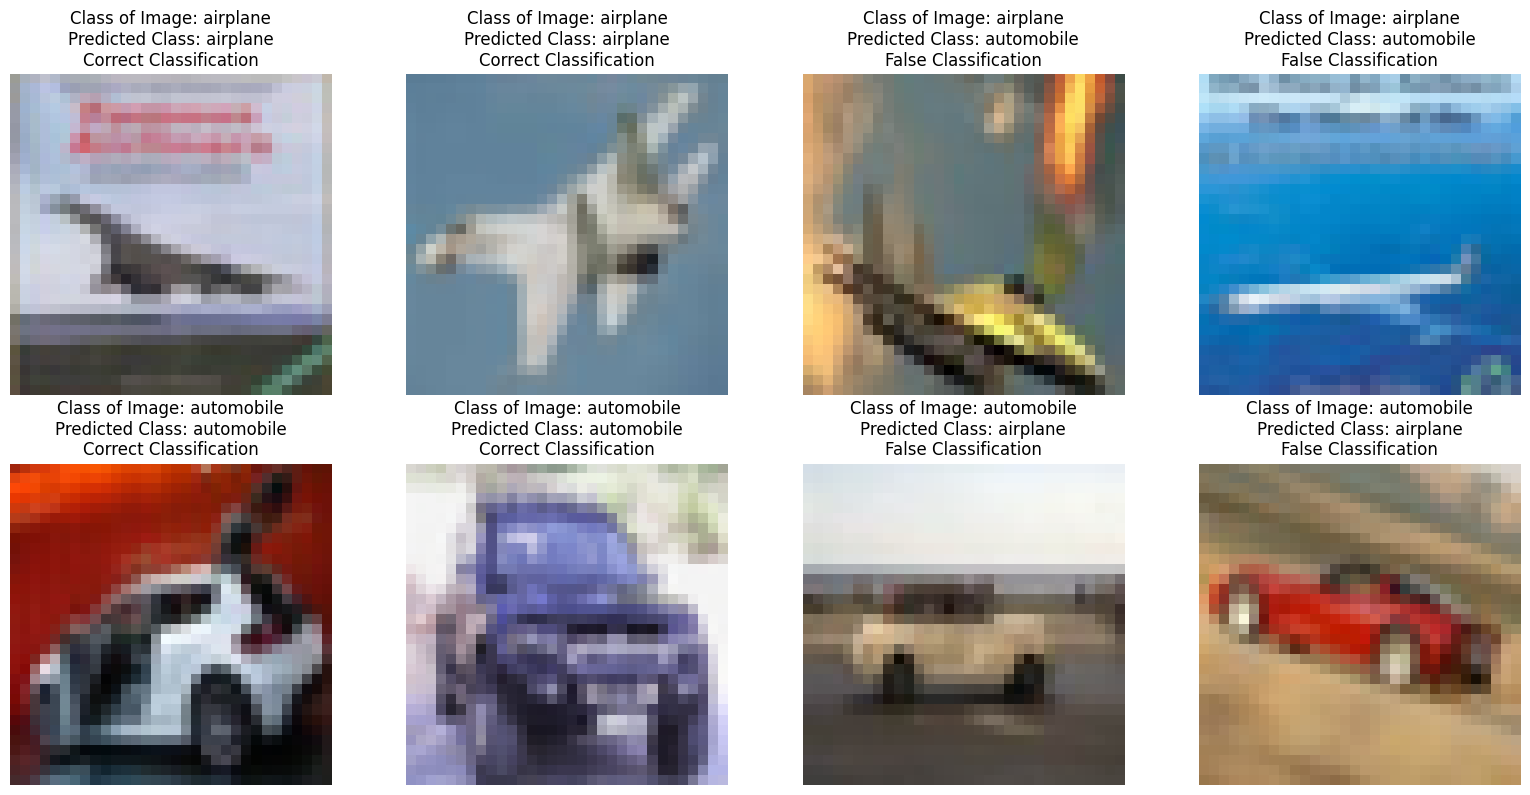

In [601]:
classification_examples(dtest,ltest,ypred_my_rbf_b,0)

Βλέπουμε ότι το SVM έχει καταφέρει αρκετά να ξεχωρίζει το γενικό σχήμα και προσανατολισμό του αυτοκινήτου από αυτό ενός αεροπλάνου. Στις περιπτώσεις αποτύχιας το κόκκινο αυτοκίνητο φαίνεατι στη φωτογραφία να έχει κλήση προς τα επάνω θυμίζοντας πολλές εικόνες όπου τα αεροπλάνα εχουν κλίση προς τα πάνω (απογείωση) κατί που ίσως ερμηνεύει την αποτυχία στην σωστή ταξινόμηση της εικόνας. Επίσης , καθώς οι εικόνες με τα αεροπλάνα είναι κυρίως μπλέ στον φόντο τότε και φωτογραφίες αυτοκινήτων με μπλέ φόντο θα μπορούσαν να οδήγησουν στο svm στο να τις ταξινομήσει λάθος. Ενδεχομένως βλέπουμε αυτό στην φωτογραφία 6.

### <center> Polynomial Kernel για 1ο Binary Πρόβλημα (Airplane vs Automobile) </center>

Σε αυτή την φάση μπορούμε να εξετάσουμε και μηχανές πολυωνυμικής μάθησης. 

Γενικά κάναμε πολλές δοκιμές που δεν θα τις παρουσιάσουμε όλες εδώ. Το σημαντικό είναι ότι πετύχαμε ποσοστά κοντά σε αυτά με RBF.

### C=1, p=3, coef0=0.1

In [ ]:
model_poly_1_b = SVC_GPU(kernel='poly', C=1,coef0=0.1)
start_time = time.time()
model_poly_1_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_poly_1_b = model_poly_1_b.predict(data_test)
actr_1=accuracy(model_poly_1_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_1=accuracy(cp.asnumpy(label_pred_model_poly_1_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_1}%")
print(f"Testing Accuracy {actst_1}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_poly_1_b))

Training Time: 0.32 seconds
Training Accuracy 94.69999999999999%
Testing Accuracy 89.75%
Accuracy: 89.75%
Success of each classification:


,Airplane,Automobile
0,88.0,91.5


Τα ποσοστά εκπαίδευσης και ελέγχου είναι παρόμοια με αυτά του rbf ενώ ακόμα και ο χρόνος εκπαίδευσης ειναι παραπλήσιος λόγω της cuml. Σε αυτό το σημείο μπορούμε να μειώσουμε την πολυπλοκότητα του μοντέλου (άρα τον βάθμο του kernel) για να φέρουμε το train και test set πλησιέστερα ως προς την ακρίβεια.

### C=1, p=2,coef0=0.2

In [ ]:
model_poly_2_b = SVC_GPU(kernel='poly', C=1,degree=2,coef0=0.2)
start_time = time.time()
model_poly_2_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_poly_2_b = model_poly_2_b.predict(data_test)
actr_2=accuracy(model_poly_2_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_2=accuracy(cp.asnumpy(label_pred_model_poly_2_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_2}%")
print(f"Testing Accuracy {actst_2}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_poly_2_b))

Training Time: 0.27 seconds
Training Accuracy 92.16%
Testing Accuracy 89.9%
Accuracy: 89.90%
Success of each classification:


,Airplane,Automobile
0,88.3,91.5


Βλέπουμε οτι το training accuracy εχει πέσει και έχει όμως πιο κοντά στο σχεδον σταθερο test accuracy. Αυτό είναι λογικό αφού μειώντας τον βαθμό του πολυωνύμου μικρύναμε και την πολυπλοκότητα του άρα την ικανότητα του να ειδικευτεί πολύ στα train data. Μπορούμε τώρα με το λιγότερο πολύπλοκο μοντέλο να αυξήσουμε την σταθερά C (σε τιμή ίση με 4 ) με την ελπίδα οτι θα βοηθήσει το απλούστερο μοντέλο να ειδικευτεί πάνω σε περισσότερα training data με τρόπο αυτή την φορά πιο φιλικό στην γενίκευση. Αυτη είναι μια δοκιμή διαισθητική και δεν στηρίζεται σε κάποια δυνατή λογική.

### C=4, p=2,coef0=0.2

In [ ]:
sigma=np.sqrt(0.5*120*np.mean(np.var(dtrain,axis=0)))
model_rbf_3_b = SVC_GPU(kernel='poly', C=4,degree=2,coef0=0.2)
start_time = time.time()
model_rbf_3_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_3_b = model_rbf_3_b.predict(data_test)
actr_3=accuracy(model_rbf_3_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_3=accuracy(cp.asnumpy(label_pred_model_rbf_3_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_3}%")
print(f"Testing Accuracy {actst_3}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_3_b))

Training Time: 0.40 seconds
Training Accuracy 95.05%
Testing Accuracy 90.5%
Accuracy: 90.50%
Success of each classification:


,Airplane,Automobile
0,88.7,92.3


Υπηρξε αναμενόμενη αύξηση των training data που ανέβασε μαζί και την επιτυχία των testing data. Γενικά φαίνεται ότι έχουμε φτάσει σε ένα threshold πανώ από το οποίο ο πολυωνυμικός kernel δεν μπορεί να παράξει svm που να διαχωρίζει καλύτερα τα δεδομένα των δύο κλάσεων. Αυτό είναι εμφανές και από το τελεύταιο παράδειγμα στο οποίο και να αύξησουμε την πολυπλκότητα το training accuracy φτανει πολυ κοντα στο 100 ενώ το test μενει σταθερο.

In [ ]:
model_rbf_4_b = SVC_GPU(kernel='poly', C=4,degree=3,coef0=0.2)
start_time = time.time()
model_rbf_4_b.fit(data_train, label_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
label_pred_model_rbf_4_b = model_rbf_4_b.predict(data_test)
actr_4=accuracy(model_rbf_4_b.predict(cp.asnumpy(data_train)),cp.asnumpy(label_train))
actst_4=accuracy(cp.asnumpy(label_pred_model_rbf_4_b),cp.asnumpy(ltest))
print(f"Training Accuracy {actr_4}%")
print(f"Testing Accuracy {actst_4}%")
accuracy_and_class(cp.asnumpy(ltest), cp.asnumpy(label_pred_model_rbf_4_b))

Training Time: 0.46 seconds
Training Accuracy 98.57000000000001%
Testing Accuracy 89.85%
Accuracy: 89.85%
Success of each classification:


,Airplane,Automobile
0,87.8,91.9


### Συγκεντρωτικα αποτελεσματα απο δοκιμες για polynomic kernel

In [ ]:
# Data for the table
data = {
    "Training Accuracy": [actr_1, actr_2, actr_3,actr_4],
    "Testing Accuracy": [actst_1, actst_2, actst_3,actst_4],
}

# Create DataFrame with row names
df = pd.DataFrame(data, index=["C=1,degree=3,gamma=\"scaled\",coef0=0.1 ","C=1,degree=2,gamma=\"scaled\",coef0=0.2 ", "C=4,degree=2,gamma=\"scaled\",coef0=0.2 ","C=4,degree=3,gamma=\"scaled\",coef0=0.2"])
display(df)

,Training Accuracy,Testing Accuracy
"C=1,degree=3,gamma=""scaled"",coef0=0.1",94.66,89.80
"C=1,degree=2,gamma=""scaled"",coef0=0.2",92.08,89.95
"C=4,degree=2,gamma=""scaled"",coef0=0.2",95.05,90.50
"C=4,degree=3,gamma=""scaled"",coef0=0.2",98.53,90.00


Μπορουμε οπως πριν να κανουμε και ενα gridsearch με την ελπίδα να βρούμε καλύτερες υπερπαραμέτρους.

In [ ]:
clf = SVC_GPU()
param_grid = [

    {"kernel": ["poly"], "C": [ 0.5, 1, 3,4,5], "degree": [2,3,5], "coef0": [0,0.1,0.2]},

]
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train),cp.asnumpy( label_train))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Grid Search Time: 25.28 seconds
Best Parameters: {'C': 4, 'coef0': 0, 'degree': 2, 'kernel': 'poly'}


Τα αποτελέσματα ακόμα και για αυτό το μοντέλο δεν διαφέρουν ουσιαστικά από τα παραπάνω.

####  k-nn Nearest Neighbour and Nesrest Centroid

In [654]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_3= KNeighborsClassifier(n_neighbors=3)
centroid = NearestCentroid()


# Fit the model
knn_1.fit(dtrain, ltrain)
knn_3.fit(dtrain, ltrain)
centroid.fit(dtrain, ltrain)


# Data for the table
data = {
    "Training Accuracy (%)": [100*knn_1.score(dtrain, ltrain), 100*knn_3.score(dtrain, ltrain), 100*centroid.score(dtrain, ltrain)],
    "Testing Accuracy (%)": [100*knn_1.score(dtest, ltest), 100*knn_3.score(dtest, ltest), 100*centroid.score(dtest, ltest)],
}

# Create DataFrame with row names
df = pd.DataFrame(data, index=["1-NN " ,"3-NN","Nearest Centroid"])
display(df)



,Training Accuracy (%),Testing Accuracy (%)
1-NN,100.00,76.95
3-NN,86.57,76.30
Nearest Centroid,70.81,72.60


Χρόνος Εκπαίδευσης και για τους 3 ταξινομητές : 0.5 seconds.

Συνεπώς, το binary svm σε όλες τις παραπάνω εκδοχές που είδαμε παρουσίαζει καλύτερο testing accuracy σε σχέση με τους k-nn αλγορίθμους και τον Nearest centroid καθώς για αυτούς το testing accuracy<80% , ενώ στα svm είδαμε testing_accuracy>80%. Αντίστοιχα όλα τα training Που πετύχαμε ήταν μεγαλύτερα από τα νούμερα για το 3-NN, Nearest Centroid. Ωστόσο, ο 1-ΝΝ εξ ορισμού έχει training accuracy =100% κατί που δεν μπορούμε να πετύχουμε σε όλα τα svm προβλήματα αλλά κυρίως σε hard margin προβλήματα που εφαρμόζονται σε feature space υπάρχει η δυνατότητα γραμμικής διαχώρισης των training δεδομένων της κλάσης. Σαφώς, τα svm είναι καλύτερα, πιο ευέλικτα και με αρκετές υπερπαραμέτρους όποτε μπορούν να λύσουν καλύτερα το πρόβλημα της cifar-10 (ή μια υποπερίπτωση του μεταξύ 2 κλάσεων).

#### MLP Neural Network with Hinge Loss

Θα συγκρίνουμε στη συνέχεια την απόδοση των SVMs που αναπτύξαμε ως προς έναν νευρωνικό δίκτυο (pytorch) με ένα κρύφο επίπεδο (100 νευρώνων) και ένα επίπεδο εξόδου (1 νευρώνας<->binary problem). Η εκπαίδεσυη του νευρωνικού θέλουμε να γίνεται με Hinge Loss:
$$L_{sample_{i}}=max(0,1-d_{i}y(x_{i}))$$
Συγκεκριμένα το ελαχιστοποιούμε ως πρός όλο το dataset:
$$L_{hinge}=\frac{1}{N}\sum_{i=1}^{N}(max(0,1-d_{i}y(x_{i})))$$

Θα αξιοποίησουμε pytorch όπως κάναμε στο 1ο παραδοτεό, ωστόσο θα εκμετάλλευτουμε απο εδώ έτοιμο το παρακάτω script που βγάλαμε με την βοήθεια του chatgpt (χρησιμοποίηθηκε για να μην οριστούν νεες συναρτησεις εκ νέου απλα για cpu). Η λογική του πάντως είναι ίδια ακριβώς με αυτή που υλοποίησαμε στην πρώτη εργασία με την διαφορά ότι έχουμε εκπαίδευση βάση του Hinge Loss.

In [749]:
import torch.nn as nn
import torch.optim as optim
# Loss function :
def HingeLoss(output, target):
    # Τarget is (1, -1)
    loss = torch.mean(torch.clamp(1 - output.view(-1)* target, min=0))  #Hinge Loss
    return loss
class HingeLossNN_b(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HingeLossNN_b, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # Raw scores (logits) for hinge loss
        return x
# Instantiate model, loss, and optimizer
model = HingeLossNN_b(120, 100, 1)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
dtrain_tensor=torch.tensor(dtrain,dtype=torch.float32)
ltrain_tensor=torch.tensor(ltrain,dtype=torch.float32)
dtest_tensor=torch.tensor(dtest,dtype=torch.float32)
ltest_tensor=torch.tensor(ltest,dtype=torch.float32)

num_epochs = 1800
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(dtrain_tensor)
    loss =HingeLoss(outputs,ltrain_tensor)  
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")

# Evaluate model
model.eval()
with torch.no_grad():
    predictions_train = model(dtrain_tensor)
    predicted_classes_train = torch.sign(predictions_train).view(-1) 
    accuracy_train = (predicted_classes_train == ltrain_tensor).float().mean()
    print(f"Train Accuracy: {100*accuracy_train:.2f}")
    
    predictions = model(dtest_tensor)
    predicted_classes = torch.sign(predictions).view(-1) 
    accuracy_test= (predicted_classes == ltest_tensor).float().mean()
    print(f"Test Accuracy: {100*accuracy_test:.2f}")

Epoch: 100, Loss: 0.4306
Epoch: 200, Loss: 0.3801
Epoch: 300, Loss: 0.3508
Epoch: 400, Loss: 0.3306
Epoch: 500, Loss: 0.3149
Epoch: 600, Loss: 0.3018
Epoch: 700, Loss: 0.2903
Epoch: 800, Loss: 0.2799
Epoch: 900, Loss: 0.2704
Epoch: 1000, Loss: 0.2615
Epoch: 1100, Loss: 0.2531
Epoch: 1200, Loss: 0.2451
Epoch: 1300, Loss: 0.2375
Epoch: 1400, Loss: 0.2302
Epoch: 1500, Loss: 0.2231
Epoch: 1600, Loss: 0.2163
Epoch: 1700, Loss: 0.2095
Epoch: 1800, Loss: 0.2029
Training Time: 10.41 seconds
Train Accuracy: 92.01
Test Accuracy: 88.40


Συνεπώς, τα Training και Test accuracies του νευρωνικού είναι πολύ κοντά σε αυτά που υπολογίσαμε με τα svm με τον rbf και polynomial kernel (κοντά στο 90%). Αυτό είναι λογικό καθώς άμα η δομή αυτού του νευρωνικού με 100 κρυφούς νευρώνες και 1 νευρώνα εξόδου , θυμίζει αρκετά αυτή ενος SVM. Άμα θυμηθούμε τον τύπο από τα SVM:
$$y(x)=\sum_{i=1}^{N_{sv}}\alpha_{i}d_{i}K(\mathbf{x}_{sv,i},\mathbf{x})+b$$
Μπορούμε από τον τύπο να δούμε μια αναλογία ανάμεσα στο svm και την έξοδο του νευρωνικού. Συγκεκριμένα, το y θυμίζει την έξοδο του νευρωνικού (μονός νευρώνας χωρίς ενεργοποίηση) και το ai*di αντιστοιχεί στα βάρη του σταδίου εξόδου , με το Κ(xi,x) να αντιστοιχεί στις εξόδους των νευρώνων του κρυφού επίπεδου. Για αυτό τον λόγο , δεν μας εκπλήσει η ομοίοτητα ως προς την επιυχία σε classification σε σύγκριση με τα SVM που αναπτύξαμε για το πρόβλημα αεροπλάνο-αμάξι.

Αντίστοιχα με sigmoid αντί για ReLU:

In [747]:
import torch.nn as nn
import torch.optim as optim
# Loss function :
def HingeLoss(output, target):
    # Τarget is (1, -1)
    loss = torch.mean(torch.clamp(1 - output.view(-1_* target, min=0))  #Hinge Loss
    return loss
class HingeLossNN_b(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HingeLossNN_b, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)  # Raw scores (logits) for hinge loss
        return x
# Instantiate model, loss, and optimizer
model = HingeLossNN_b(120, 100, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
dtrain_tensor=torch.tensor(dtrain,dtype=torch.float32)
ltrain_tensor=torch.tensor(ltrain,dtype=torch.float32)
dtest_tensor=torch.tensor(dtest,dtype=torch.float32)
ltest_tensor=torch.tensor(ltest,dtype=torch.float32)

num_epochs = 1900
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(dtrain_tensor)
    loss =HingeLoss(outputs,ltrain_tensor)  
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")

# Evaluate model
model.eval()
with torch.no_grad():
    predictions_train = model(dtrain_tensor)
    predicted_classes_train = torch.sign(predictions_train).view(-1) 
    accuracy_train = (predicted_classes_train == ltrain_tensor).float().mean()
    print(f"Train Accuracy: {100*accuracy_train:.2f}")
    
    predictions = model(dtest_tensor)
    predicted_classes = torch.sign(predictions).view(-1) 
    accuracy_test= (predicted_classes == ltest_tensor).float().mean()
    print(f"Test Accuracy: {100*accuracy_test:.2f}")

Epoch: 100, Loss: 0.4314
Epoch: 200, Loss: 0.3975
Epoch: 300, Loss: 0.3740
Epoch: 400, Loss: 0.3536
Epoch: 500, Loss: 0.3335
Epoch: 600, Loss: 0.3133
Epoch: 700, Loss: 0.2927
Epoch: 800, Loss: 0.2714
Epoch: 900, Loss: 0.2500
Epoch: 1000, Loss: 0.2289
Epoch: 1100, Loss: 0.2081
Epoch: 1200, Loss: 0.1879
Epoch: 1300, Loss: 0.1690
Epoch: 1400, Loss: 0.1514
Epoch: 1500, Loss: 0.1353
Epoch: 1600, Loss: 0.1202
Epoch: 1700, Loss: 0.1064
Epoch: 1800, Loss: 0.0937
Epoch: 1900, Loss: 0.0823
Training Time: 9.83 seconds
Train Accuracy: 97.20
Test Accuracy: 85.80


Παρατηρούμε ότι καταλήγουμε σε overfit στα training data εδώ. Αυτό μάλλον είναι λόγω της σιγμοείδους η οποία μειωνεκτεί σε σχέση με την ReLU , καθώς η παράγωγος της μηδενίζεται προς δυο κατεύθυνσεις (σε αντίθεση της relu μονο προς τα αρνητικα) και έχουμε τον πιθανό εγκλώβισμο σε τοπικό ελάχιστο που ευννοεί τα training data. 

# <center> <b> Multi-Class Classification SVM </b> </center>

Έχοντας επιλύσει , τα παραπάνω δυαδικά προβλήματα τώρα μπορούμε να εκμεταλλευτούμε την γνώση που αποκτήσαμε μελετώντας τα binary προβλήματα προκείμενου να δούμε το συνολικό πρόβλημα κατηγοριοποίησης για το όποιο προσφέρεται η Cifar-10. 

Για αρχή ας εξέτασουμε το Linear my_SVM για όλες τις κλάσεις. Περιμένουμε από όσα είδαμε στα Binary ότι και εδώ η λειτουργία της δεν είναι η βέλτιστη. Πράγματι έχουμε: 

### Linear Multi-Class

Training Time: 1953.35 seconds
Training Accuracy 42.358000000000004
Testing Accuracy 40.68


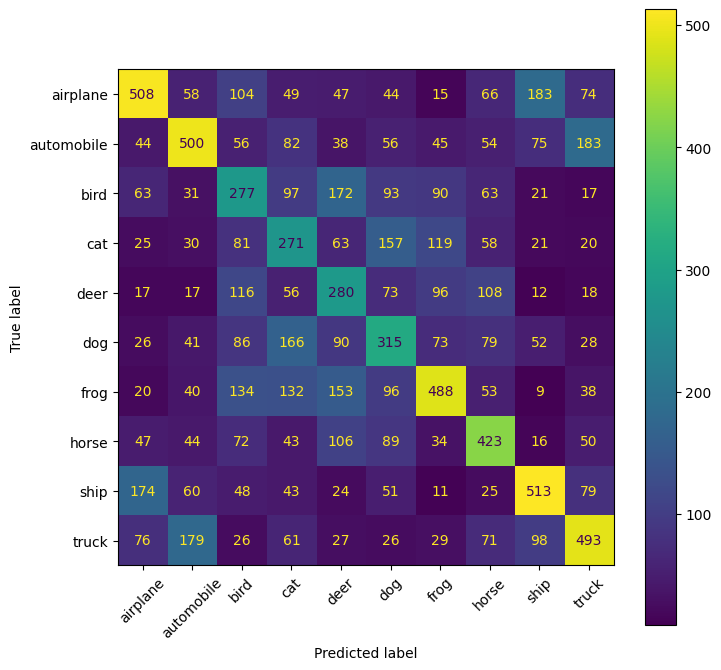

In [645]:
obj_my_lin_mul=my_SVM(kernel="linear",C=1.0)
start_time = time.time()
obj_my_lin_mul.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_my_lin_mul=obj_my_lin_mul.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(obj_my_lin_mul.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}")
print(f"Testing Accuracy {accuracy(ypred_my_lin_mul,label_test_cifar10_np)}")
confusion_matrix_plot(ypred_my_lin_mul,label_test_cifar10_np)

Εκτελώντας ενα LinearSCV μέσα σε OneVsOneClassifier wraper μπορούμε να δούμε αμα το αποτέλεσμα ως προς το test accuracy που βγάλαμε με την my_SVM είναι ορθό:

In [764]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(C=1))
clf.fit(data_train_pca_np, label_train_cifar10_np)

# Predict classes
predictions = clf.predict(data_test_pca_np)

# Get decision function scores
decision_scores = clf.decision_function(data_test_pca_np)
print(f"Training Accuracy: {accuracy(np.argmax(clf.decision_function(data_train_pca_np),axis=1),label_train_cifar10_np):.2f}%")
print(f"Testing Accuracy: {accuracy(predictions,label_test_cifar10_np):.2f}%")

Training Accuracy: 41.93%
Testing Accuracy: 41.12%


Τα αποτελέσματα είναι αρκετά κοντά μεταξύ τους. Επομέμως, έχουμε άκομα ενα τεκμήριο για την ορθή λειτουργία της my_SVM και μάλιστα φαίνεται ότι έχουμε για τα Linear SVM αποτελέσματα που είναι αρκετά κοντά στους classifier nearest-neighbour και nearest centroid. Γενικά το Linear SVM δεν είναι το βέλτιστο machine για τα προβλήματα που αφορούν τη cifar10 (είτε το multiclass είτε το Binary).

### Γενικές δοκιμές με RBF και Polynomic Kernels

Απο τα binary προβλήματα είδαμε την ικανότητα των svm να εκπαίδευονται καλύτερα πάνω σε RBF και Polynomic Kernels και πάνω στους χώρους που δεν εξετάζουμαι καθώς εκμεταλλευόμαστε το kernel trick να κάνουν ικανοποιητικά διαχωρίσιμα τα δεδομένα διαφορετικών κλάσεων. Για αυτό θα κάνουμε κάποιες δοκιμές με την ελπίδα να φτίαξουμε έναν ικανοποιητικό SVM classifier για το Multi class πρόβλημα.

#### Polynomial, C=4, p=2 (degree),coef0=0.1

Προηγουμένως αποτελούσε καλό συνδιασμό στο 1ο binary πρόβλημα , τώρα μπορούμε να δούμε πόσο καλός είναι στο multiclass πρόβλημα:

Training Time: 1504.10 seconds
Training Accuracy 71.352
Testing Accuracy 54.37


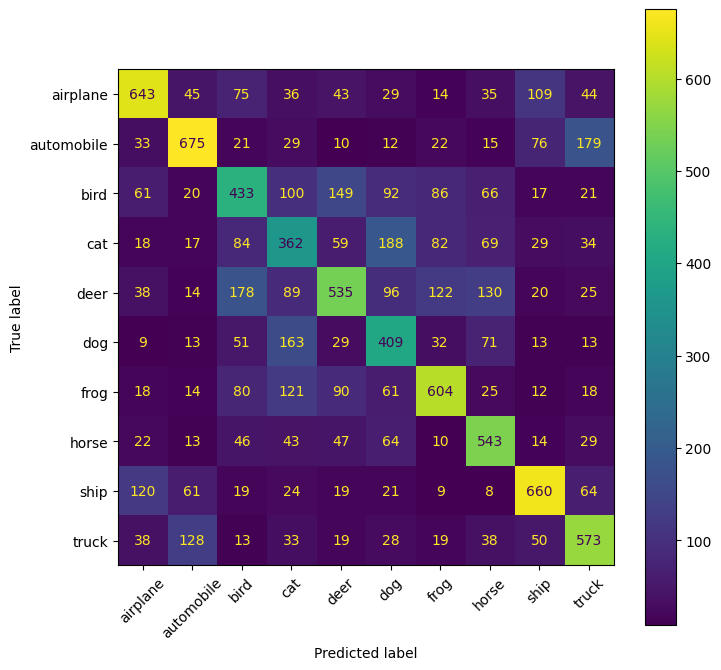

In [646]:
obj_my_pol_mul=my_SVM(kernel="polynomial",C=4.0,p=2,coef0=0.1)
start_time = time.time()
obj_my_pol_mul.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_my_pol_mul=obj_my_pol_mul.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(obj_my_pol_mul.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}")
print(f"Testing Accuracy {accuracy(ypred_my_pol_mul,label_test_cifar10_np)}")
confusion_matrix_plot(ypred_my_pol_mul,label_test_cifar10_np)

In [765]:
accuracy_and_class(ypred_my_pol_mul,label_test_cifar10_np)


Accuracy: 54.37%
Success of each classification:


,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,64.3,67.5,43.3,36.2,53.5,40.9,60.4,54.3,66.0,57.3


Είναι εμφανές ότι έχουμε καλη κατηγοριοποίηση με αυτόν τον Kernel και υπερπαραμέτρους ως προς το διαχωρισμό airplanes και automobiles, ωστόσο απο το confusion table μπορούμε να δούμε ότι σε άλλα προβλήματα η καθέ μια από τις δυο κλάσεις είναι σε μικρότερο ή σε μεγαλύτερο βαθμό ευάλωτη σε λάθος κατηγοριοποίηση. Για παράδειγμα το αεροπλάνο και το πλοίο μπερδεύονται συχνά μεταξύ τους (όχι όμως στον βαθμό σκύλου-γάτας). Λόγω του χάσματος μεταξύ του Training και Testing Accuracy , έχουμε ένδειξη ότι το μοντέλο ίσως έχει υπερεκπεδευθεί στα training data. Για να ελέγξουμε αυτή την υπόθεση μπορούμε να ανάγουμε το πρόβλημα στην hard-margin μορφή του και να δούμε κατά πόσο αλλάζει το test accuracy. Χρησιμοποιουμε την υλοποίηση μας my_SVM

Training Time: 1536.51 seconds
Training Accuracy 99.53800000000001%
Testing Accuracy 51.05%


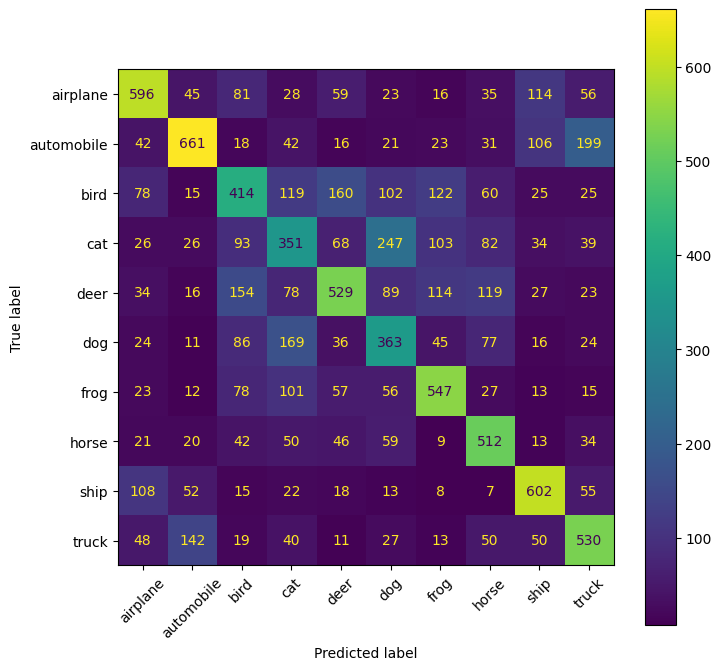

Accuracy: 51.05%
Success of each classification:


,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,59.6,66.1,41.4,35.1,52.9,36.3,54.7,51.2,60.2,53.0


In [541]:
objpol_5=my_SVM(kernel="polynomial",C="infinity",p=3,coef0=1)
start_time = time.time()
objpol_5.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypredobj5=objpol_5.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(objpol_5.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}%")
print(f"Testing Accuracy {accuracy(ypredobj5,label_test_cifar10_np)}%")
confusion_matrix_plot(ypredobj5,label_test_cifar10_np)
accuracy_and_class(ypredobj5,label_test_cifar10_np)


Παρατηρούμε ότι το Test Accuracy είναι σχετικά κοντά με πρίν και έχει πέσει γιατί απλά αυξήθηκε το overfitting στα training data. Αυτό είναι ένα γενικότερο πρόβλημα που φαίνεται να εμφανίζεται γενικά στα hard margin προβλήματα. Κατά αντιστοιχία ακολούθει το hard-margin Multi-class πρόβλημα για RBF Kernel.

Training Time: 1877.90 seconds
Training Accuracy 100.0
Testing Accuracy 54.14


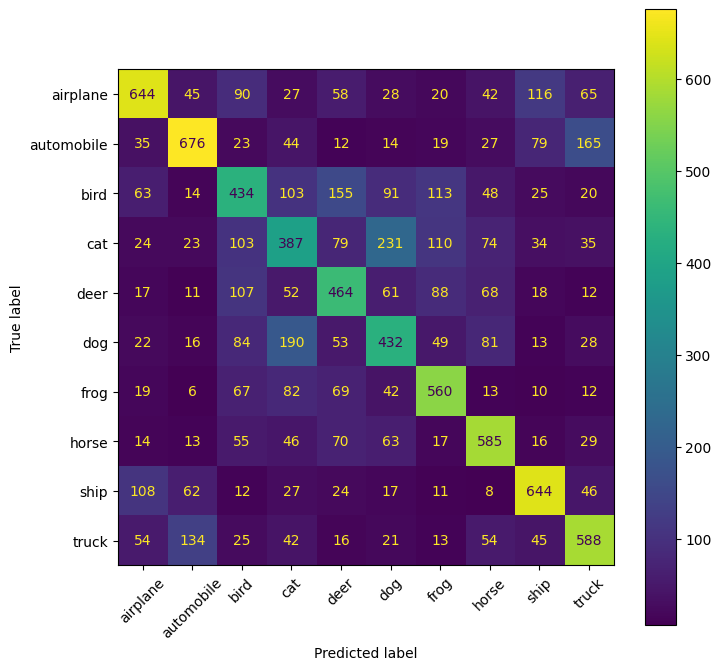

In [336]:
obj_h_rbf_inf=my_SVM(kernel="rbf",C="infinity",sigma=np.sqrt(0.5*120*np.mean(np.var(data_train_pca_np,axis=0))))
start_time = time.time()
obj_h_rbf_inf.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_h_rbf=obj_h_rbf_inf.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(obj_h_rbf_inf.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}")
print(f"Testing Accuracy {accuracy(ypred_h_rbf,label_test_cifar10_np)}")
confusion_matrix_plot(ypred_h_rbf,label_test_cifar10_np)

Το ποσοστό στο accuracy είναι κοντινό με τα προηγούμενα και έχουμε πρακτικά overfit στα train data λόγω του hard margin προβλήματος. (χάσαμ train-test περίπου 50%). Τo overfit γίνεται αντιληπτό και από το κάτω παράδειγμα. Προσπαθώντας για RBF να μειώσουμε το C (άρα να κάνουμε το svm πιο ανεκτικό σε λάθη άρα πιο ικανό σε γενίκευση) έχουμε για C=2.5

Training Time: 2792.48 seconds
Training Accuracy 69.422
Testing Accuracy 54.74


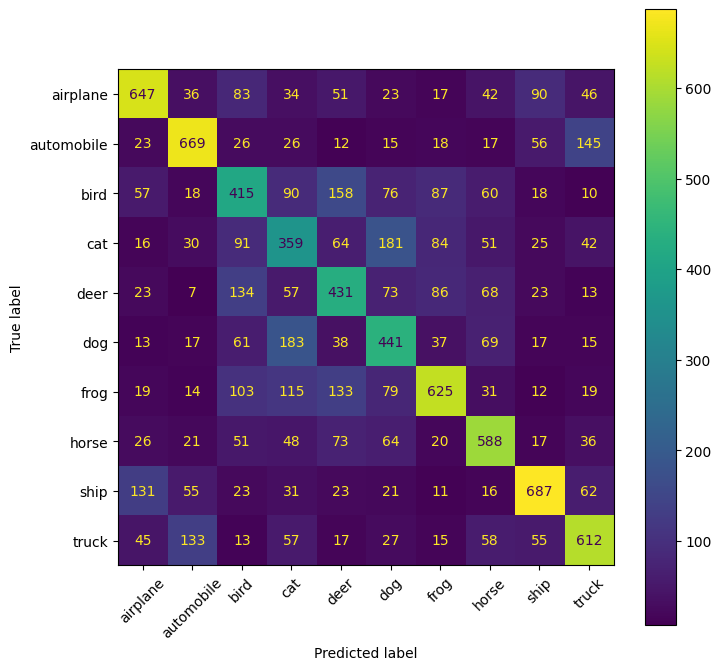

In [203]:
obj_h_rbf=my_SVM(kernel="rbf",C=2.5,sigma=np.sqrt(0.5*120*np.mean(np.var(data_train_pca_np,axis=0))))
start_time = time.time()
obj_h_rbf.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypred_h_rbf=obj_h_rbf.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(obj_h_rbf.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}")
print(f"Testing Accuracy {accuracy(ypred_h_rbf,label_test_cifar10_np)}")
confusion_matrix_plot(ypred_h_rbf,label_test_cifar10_np)

Training Time: 1785.80 seconds
Training Accuracy 90.436
Testing Accuracy 54.7


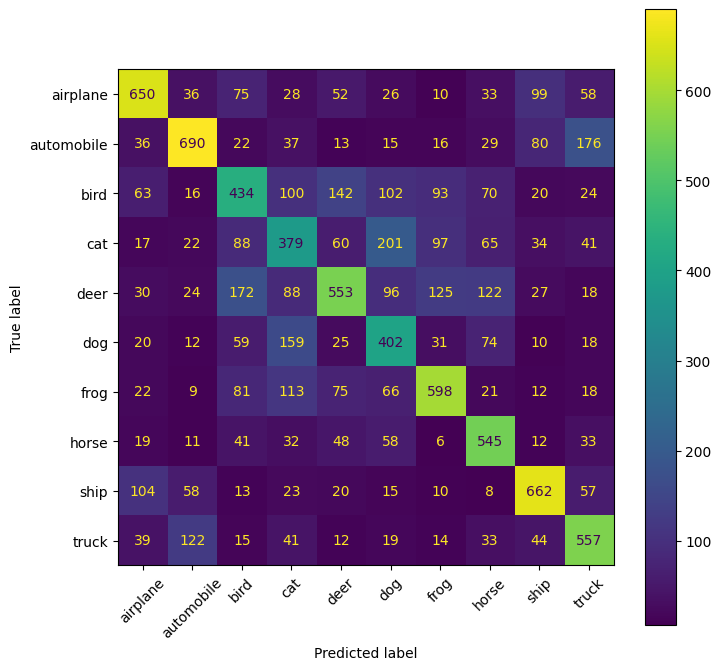

In [344]:
objpol_4=my_SVM(kernel="polynomial",C=3.0,p=3,coef0=1)
start_time = time.time()
objpol_4.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypredobj4=objpol_4.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(objpol_4.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}")
print(f"Testing Accuracy {accuracy(ypredobj4,label_test_cifar10_np)}")
confusion_matrix_plot(ypredobj4,label_test_cifar10_np)


In [752]:
accuracy_and_class(ypredobj4, label_test_cifar10_np)

Accuracy: 54.70%
Success of each classification:


,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,65.0,69.0,43.4,37.9,55.3,40.2,59.8,54.5,66.2,55.7


In [162]:
objpol_2=my_SVM(kernel="polynomial",C=3.0,p=3)
objpol_2.fit_fun_1v1(data_train_pca_np)
ypredobj2=objpol_2.pred_fun_1v1(data_test_pca_np)
accuracy(ypredobj2,label_test_cifar10_np)

(0, 1) 0 1
[1.31429215e-08 2.99999984e+00 2.99999952e+00 ... 3.60161397e-08
 5.93930221e-08 2.99999993e+00]
1
(0, 2) 0 2
[5.11445955e-08 2.99999994e+00 2.99999997e+00 ... 7.86960277e-08
 4.77199236e-01 2.99999999e+00]
1
(0, 3) 0 3
[1.65435161e-01 2.99999975e+00 1.84077305e+00 ... 1.27267879e-08
 5.40261169e-08 1.07891859e-07]
1
(0, 4) 0 4
[9.31729300e-08 9.94643412e-01 2.99999997e+00 ... 2.99999951e+00
 2.99999920e+00 1.14028618e-07]
1
(0, 5) 0 5
[1.29056825e-08 2.99999997e+00 2.99999999e+00 ... 9.11563139e-10
 6.04859003e-09 2.99999999e+00]
1
(0, 6) 0 6
[9.09177027e-01 1.11725689e-08 1.09192423e+00 ... 2.30537549e-09
 1.36625276e-09 1.86887169e-09]
1
(0, 7) 0 7
[3.72132982e-08 7.47816794e-08 3.00000000e+00 ... 2.81033592e+00
 1.13212321e-08 1.20053625e-07]
1
(0, 8) 0 8
[5.71764940e-01 2.08611909e+00 3.24544487e-08 ... 2.68086514e+00
 2.99999991e+00 2.99999986e+00]
1
(0, 9) 0 9
[5.51627462e-01 2.99999994e+00 6.93499690e-01 ... 2.99999999e+00
 6.32769898e-09 9.89613461e-09]
1
(1, 2) 1 2

Training Time: 1384.97 seconds
Training Accuracy 59.702
Testing Accuracy 51.910000000000004


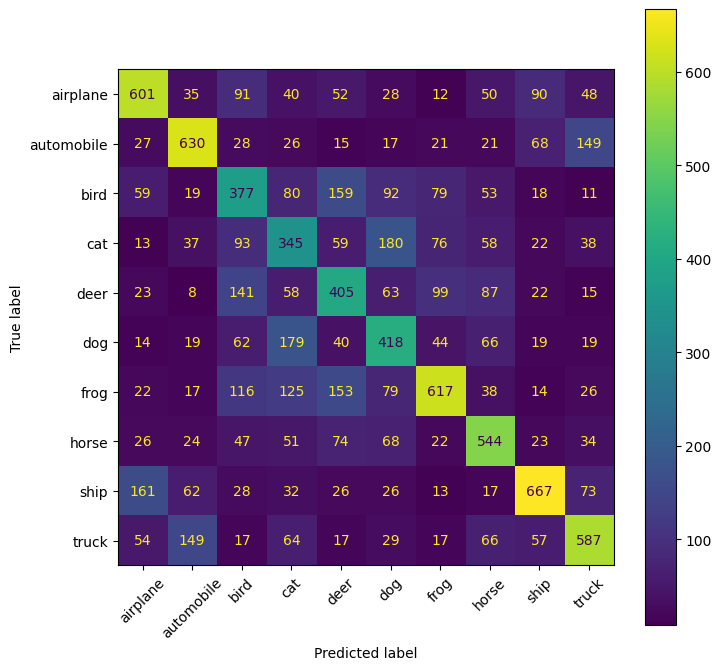

In [279]:
objrbf_1=my_SVM(kernel="rbf",C=1.0,sigma=np.sqrt(0.5*data_train_pca_np.shape[1]*np.mean(np.var(data_train_pca_np,axis=0))))
start_time = time.time()
objrbf_1.fit_fun_1v1(data_train_pca_np)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")
ypredrbf_1=objrbf_1.pred_fun_1v1(data_test_pca_np)
print(f"Training Accuracy {accuracy(objrbf_1.pred_fun_1v1(data_train_pca_np),label_train_cifar10_np)}")
print(f"Testing Accuracy {accuracy(ypredrbf_1,label_test_cifar10_np)}")
confusion_matrix_plot(ypredrbf_1,label_test_cifar10_np)


### Αναζήτηση με GridSearch

Ακολουθουν κάποιες διερευνησεις υπερπαραμετρικες με gridsearch 

In [ ]:
clf = SVC_GPU()
param_grid = [
    {"kernel": ["rbf"],"C": [ 0.2, 0.5,1,2,3.5,5,10,1e6]},
]
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=2)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train_pca_cp), cp.asnumpy(label_train_cp))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..................................C=0.2, kernel=rbf; total time=   7.2s
[CV] END ..................................C=0.2, kernel=rbf; total time=   3.8s
[CV] END ..................................C=0.2, kernel=rbf; total time=   3.9s
[CV] END ..................................C=0.2, kernel=rbf; total time=   4.2s
[CV] END ..................................C=0.2, kernel=rbf; total time=   3.8s
[CV] END ..................................C=0.5, kernel=rbf; total time=   3.9s
[CV] END ..................................C=0.5, kernel=rbf; total time=   4.1s
[CV] END ..................................C=0.5, kernel=rbf; total time=   4.3s
[CV] END ..................................C=0.5, kernel=rbf; total time=   3.9s
[CV] END ..................................C=0.5, kernel=rbf; total time=   3.9s
[CV] END ....................................C=1, kernel=rbf; total time=   4.7s
[CV] END ....................................C=1,

In [ ]:
clf = SVC_GPU()
param_grid = [
    {"kernel": ["rbf"],"C": [ 4, 4.5,5,5.5,6,6.5,7,9]},
]
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=2)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train_pca_cp), cp.asnumpy(label_train_cp))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ....................................C=4, kernel=rbf; total time=   8.6s
[CV] END ....................................C=4, kernel=rbf; total time=   7.7s
[CV] END ....................................C=4, kernel=rbf; total time=   7.6s
[CV] END ....................................C=4, kernel=rbf; total time=   7.6s
[CV] END ....................................C=4, kernel=rbf; total time=   7.7s
[CV] END ..................................C=4.5, kernel=rbf; total time=   8.1s
[CV] END ..................................C=4.5, kernel=rbf; total time=   8.2s
[CV] END ..................................C=4.5, kernel=rbf; total time=   8.0s
[CV] END ..................................C=4.5, kernel=rbf; total time=   8.2s
[CV] END ..................................C=4.5, kernel=rbf; total time=   7.8s
[CV] END ....................................C=5, kernel=rbf; total time=   8.5s
[CV] END ....................................C=5,

In [ ]:
clf = SVC_GPU()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, verbose=2)

grid_search.fit(cp.asnumpy(data_train_pca_cp), cp.asnumpy(label_train_cp))

print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..................................C=3.5, kernel=rbf; total time=   9.4s
[CV] END ..................................C=3.5, kernel=rbf; total time=   6.7s
[CV] END ..................................C=3.5, kernel=rbf; total time=   6.8s
[CV] END ....................................C=4, kernel=rbf; total time=   7.2s
[CV] END ....................................C=4, kernel=rbf; total time=   7.1s
[CV] END ....................................C=4, kernel=rbf; total time=   8.0s
[CV] END ..................................C=4.5, kernel=rbf; total time=   7.5s
[CV] END ..................................C=4.5, kernel=rbf; total time=   7.6s
[CV] END ..................................C=4.5, kernel=rbf; total time=   7.4s
[CV] END ....................................C=5, kernel=rbf; total time=   7.9s
[CV] END ....................................C=5, kernel=rbf; total time=   7.8s
[CV] END ....................................C=5,

In [ ]:
param_grid_pol_spec = [
    #{"kernel": ["rbf"],"C": [ 3.5, 4,4.5,5,5.5,8,10,1e6]},
    {"kernel": ["poly"], "C": [  3,4,5], "degree": [2,3], "coef0": [0.1,0.2]},
]
clf = SVC_GPU()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid_pol_spec, cv=5, verbose=2)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train_pca_cp), cp.asnumpy(label_train_cp))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=  11.0s
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=  10.0s
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=  10.3s
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=  10.3s
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=  10.1s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  13.0s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  13.0s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  13.0s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  13.0s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  13.1s
[CV] END ..............C=3, coef0=0.2, degree=2, kernel=poly; total time=  10.5s
[CV] END ..............C=3, coef0=0.2, degree=2,

In [ ]:
param_grid_pol_spec = [
    #{"kernel": ["rbf"],"C": [ 3.5, 4,4.5,5,5.5,8,10,1e6]},
    {"kernel": ["poly"], "C": [5,6,7], "degree": [2,3], "coef0": [0.2,0.4]},
]
clf = SVC_GPU()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid_pol_spec, cv=5, verbose=2)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train_pca_cp), cp.asnumpy(label_train_cp))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..............C=5, coef0=0.2, degree=2, kernel=poly; total time=  14.3s
[CV] END ..............C=5, coef0=0.2, degree=2, kernel=poly; total time=  13.7s
[CV] END ..............C=5, coef0=0.2, degree=2, kernel=poly; total time=  13.8s
[CV] END ..............C=5, coef0=0.2, degree=2, kernel=poly; total time=  13.6s
[CV] END ..............C=5, coef0=0.2, degree=2, kernel=poly; total time=  13.7s
[CV] END ..............C=5, coef0=0.2, degree=3, kernel=poly; total time=  15.7s
[CV] END ..............C=5, coef0=0.2, degree=3, kernel=poly; total time=  15.6s
[CV] END ..............C=5, coef0=0.2, degree=3, kernel=poly; total time=  15.6s
[CV] END ..............C=5, coef0=0.2, degree=3, kernel=poly; total time=  15.5s
[CV] END ..............C=5, coef0=0.2, degree=3, kernel=poly; total time=  15.5s
[CV] END ..............C=5, coef0=0.4, degree=2, kernel=poly; total time=  15.3s
[CV] END ..............C=5, coef0=0.4, degree=2,

In [ ]:
param_grid_pol_spec = [
    #{"kernel": ["rbf"],"C": [ 3.5, 4,4.5,5,5.5,8,10,1e6]},
    {"kernel": ["poly"], "C": [  3,4,5], "degree": [2,3], "coef0": [0.1,0.2]},
]
clf = SVC_GPU()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid_pol_spec, cv=2, verbose=2)
start_time = time.time()
grid_search.fit(cp.asnumpy(data_train_pca_cp), cp.asnumpy(label_train_cp))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Grid Search Time: {elapsed_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=  22.9s
[CV] END ..............C=3, coef0=0.1, degree=2, kernel=poly; total time=   9.2s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  10.7s
[CV] END ..............C=3, coef0=0.1, degree=3, kernel=poly; total time=  10.7s
[CV] END ..............C=3, coef0=0.2, degree=2, kernel=poly; total time=   9.3s
[CV] END ..............C=3, coef0=0.2, degree=2, kernel=poly; total time=   8.9s
[CV] END ..............C=3, coef0=0.2, degree=3, kernel=poly; total time=  10.9s
[CV] END ..............C=3, coef0=0.2, degree=3, kernel=poly; total time=  10.6s
[CV] END ..............C=4, coef0=0.1, degree=2, kernel=poly; total time=   9.5s
[CV] END ..............C=4, coef0=0.1, degree=2, kernel=poly; total time=   9.5s
[CV] END ..............C=4, coef0=0.1, degree=3, kernel=poly; total time=  11.3s
[CV] END ..............C=4, coef0=0.1, degree=3,

In [657]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_3= KNeighborsClassifier(n_neighbors=3)
centroid = NearestCentroid()


# Fit the model
knn_1.fit(data_train_pca_np, label_train_cifar10_np)
knn_3.fit(data_train_pca_np, label_train_cifar10_np)
centroid.fit(data_train_pca_np, label_train_cifar10_np)


# Data for the table
data = {
    "Training Accuracy (%)": [100*knn_1.score(data_train_pca_np, label_train_cifar10_np), 100*knn_3.score(data_train_pca_np, label_train_cifar10_np), 100*centroid.score(data_train_pca_np, label_train_cifar10_np)],
    "Testing Accuracy (%)": [100*knn_1.score(data_test_pca_np, label_test_cifar10_np), 100*knn_3.score(data_test_pca_np, label_test_cifar10_np), 100*centroid.score(data_test_pca_np, label_test_cifar10_np)],
}

# Create DataFrame with row names
df = pd.DataFrame(data, index=["1-NN " ,"3-NN","Nearest Centroid"])
display(df)



,Training Accuracy (%),Testing Accuracy (%)
1-NN,100.000,38.28
3-NN,61.776,36.30
Nearest Centroid,27.132,28.10


Χρόνος Εκπαίδευσης και για τους 3 ταξινομητές : 17 seconds.

Πάλι, το svm σχεδόν σε όλες τις παραπάνω εκδοχές που είδαμε παρουσίαζει καλύτερο testing accuracy σε σχέση με τους k-nn αλγορίθμους και τον Nearest centroid καθώς για αυτούς το testing accuracy<40% , ενώ στα svm είδαμε testing_accuracy>40% (χειρότερο στο γραμμικό). Αντίστοιχα όλα τα training Που πετύχαμε ήταν μεγαλύτερα από τα νούμερα για το 3-NN, Nearest Centroid. Ωστόσο, ο 1-ΝΝ εξ ορισμού όπως είδαμε και πρωτύτερα έχει training accuracy =100% κατί που δεν μπορούμε να πετύχουμε σε όλα τα svm προβλήματα αλλά κυρίως σε hard margin προβλήματα που εφαρμόζονται σε feature space υπάρχει η δυνατότητα γραμμικής διαχώρισης των training δεδομένων της κλάσης. 

Ίδιαίτερα στο multi-class πρόβλημα είναι εμφανές από τα test accuracies στο πόσο πιο καλά μοντέλα είναι τα svm για γενίκευση από αυτούς τους ταξινομητές πλησιέστερου γείτονα και κέντρου κλάσης. Βέβαια, είναι και πιο πολύπλοκα τα μοντέλα αυτά καθώς στο Multiclass της cifar10 έχω πρακικά 45 SVMs (1v1) που επεξεργάζονται τα δεδομένα εισόδου και μετά απο ψηφοφορία ανατίθεται μια εκτίμηση της κλάσης στην οποία πιθανώς να ανήκει το δείγμα εισόδου.(Άρα Ν ψηφοφορίες μετά απο Ν εκπαιδεύσεις για όλα τα δείγματα ενος συνόλου ελέγχου).

### Νευρωνικό Δίκτυο για Multi-Class Πρόβλημα (Υλοποίηση 1ου παραδοτέου με Multiclass Hinge Loss)

In [658]:
def split_shuffle(size,num_batches): 
    range_start = 0
    range_end =size
    #Δημιουργώ Πίνακα 
    indices = np.arange(range_start, range_end)
    np.random.shuffle(indices)

    #Σπάω 
    shuffled_list = np.array_split(indices, num_batches)
    return shuffled_list


In [ ]:
import torch.nn as nn
import torch.optim as optim


def accuracy_tensor(label_pred,label_test):
        arr_of_error=label_pred-label_test
        num_zeros = torch.count_nonzero(arr_of_error==0)
        accuracy=num_zeros/len(label_test)*100
        return accuracy

def Training_process(model,data_train,label_train,optimizer,loss_fn):
       #Ετοιμάζω το model του νευρωνικού για το στάδιο εκπαίδευσης
       model.train()

       #Forward Διάδοση των δεδομένων Εκπαίδευσης απο το Layer εισόδου στο Layer Εξόδου 
       label_logits = model(data_train)  #Η έξοδος του στρώματος (layer) εξόδου είναι σε μορφή logits-> W*x+b δηλαδή δεν περνάει απο συνάρτηση ενεργοποιήσης 
       label_pred=torch.argmax(label_logits,dim=1) #Βάση του πιο μέγαλου logit απο τις εξόδους των νευρώνων του layer εξόδου, επιλέγω το μέγιστο (μεγαλύτερη τιμή ->μεγαλύτερη πιθανότητα για την κλάσση που αντιπροσωπεύει ο νευρώνας εξόδου).

        #Υπολογίζω τις απώλειες κάθε δείγματος στο batch και παίρνω τον μέσο όρο loss 
       loss = loss_fn(label_logits,label_train) #hinge_loss
       acc = accuracy_tensor(label_pred,label_train) 

        #Αρχικοποιούμε τα grads στο μηδέν ώστε να μην μεταφερθεί πληροφορία στην διαδικασία βελτιστοποίησης απο τις παραγώγους της προηγούμενης οπισθοδιάδοσης.
       optimizer.zero_grad()

        # Οπισθοδιάδοση (Back Propagation)
       loss.backward()

        #Ενημέρωση Συναπτικών Βαρών και μοντέλου
       optimizer.step()

       return loss,acc

def Testing_process(model,data_test,label_test,loss_fn):
       #Το μοντέλο ετοιμάζεται για έλεγχο. Θα αγνοήσει dropouts, και άλλες διαδικασίες που εφαρμόστηκαν κατά την εκπαίδευση του νερυωνικού αλλά η εφαρμογή στον έλεγχο θα οδηγούσε σε αλλιώση του μοντέλου.
       model.eval()
       with torch.inference_mode():
              # Πέρασμα (forward) των δεδομένων ελέγχου από το νευρωνικό
              test_logits = model(data_test) 
              #Η έξοδος με την μεγαλύτερη τιμή στο Layer εξόδου αντιστοιχεί στην πιο πιθανή κλάση στην οποία ανήκει συγκεκριμένο δεδομένο εισόδου. Επομένως κατηγοροποιούμε το δεδομένο ελέγχου σε αυτή την κλάση.
              test_pred=torch.argmax(test_logits,dim=1)
              #Υπολογίζω απώλεια και ακρίβεια κατηγοροποίησης με χρήση των πραγματικών ετικετών ελέγχου (label_test) των δεδομένων ελέγχου (data_test)
              test_loss = loss_fn(test_logits,label_test)
              test_acc = accuracy_tensor(test_pred,label_test)  
       return test_loss,test_acc          


Η MultiMarginLoss είναι πρακτικά η προέκταση της έννοιας του hinge loss σε multiclass πρόβλημα. 

In [ ]:

def training_testing(model,epochs,learning_rate,mmnt,data_train,label_train,data_test,label_test,batch_num,cv):
    loss_fn =nn.MultiMarginLoss()  #Η συνάρτηση απώλειας  επιλέγεται η Hinge Loss
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate,momentum=mmnt)  #Ως αλγόριθμος βελτιστοποιήσης επιλέγεται η Stohastic Gradient Descent
    list_test_loss=[]
    list_train_loss=[]
    list_train_acc=[]
    list_test_acc=[]

    start_time = time.time()
    for epoch in range(epochs):

        mean_loss=0
        mean_acc=0
        shuffled_list=split_shuffle(len(data_train),batch_num) #Κάθε εποχή δημιουργούνται νέα batches από το συνολικό batch εκπαίδευσης (data_train)
        for k in range(len(shuffled_list)):
            ### Training
            loss,acc=Training_process(model,data_train[shuffled_list[k]],label_train[shuffled_list[k]],optimizer,loss_fn) #Σε κάθε batch κανώ forward στο δίκτυο και επείτα οπισθοδίαδοση για να ενημερωθούν τα βάρη
            mean_loss+=loss
            mean_acc+=acc
        mean_acc=mean_acc/len(shuffled_list)   #Επιλέγουμε να κρατηθεί ο μέσος όρος της επιτυχίας (accuracy) και απώλειας (loss) των επιτυχιών και απωλειών των (mini-) batches κατά την διαρκεία της εποχής.
        mean_loss=mean_loss/len(shuffled_list)  
        list_train_loss.append(mean_loss)
        list_train_acc.append(mean_acc)

         ### Testing
        if cv==False:    #cv=Cross-Validation. Κατά το Cross-Validation οτάν συμβαίνει η εκπαίδευση δεν χρειάζομαι τα print ανά εποχή αλλά και ούτε να πραγματοποίω καποία παράλληλη επικύρωση/έλεγχο

            test_loss,test_acc =Testing_process(model,data_test,label_test,loss_fn) #Διενεργώ Έλεγχο με τα δεδομένα Ελέγχου data_test

            list_test_loss.append(test_loss)
            list_test_acc.append(test_acc)
        
            # Τυπώνω ανά 10 εποχές την απώλεια και επιτυχία αξιολόγησης κατά την διάρκεια της εκπαίδευσης και του ελέγχου.
            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Train Loss: {mean_loss:.5f}, Train Accuracy: {mean_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    end_time=time.time()
    elapsed_time=end_time-start_time
    print(f"Training Time: {elapsed_time}")
    return list_train_loss,list_test_loss,list_train_acc,list_test_acc  #τα επιστρέφω για να τα κάνω plot.

In [698]:
def train_test_plot(model,epochs,lr,mom,data_train,label_train,data_test,label_test,nb,cv):
    ltr_loss,lts_loss,ltr_acc,lts_acc=training_testing(model,epochs,lr,mom,data_train,label_train,data_test,label_test,nb,cv) #train and validate-test

    epoch_axis = np.arange(1, epochs + 1)

    ltr_loss_cpu=[loss.cpu().item() for loss in ltr_loss]
    lts_loss_cpu = [loss.cpu().item() for loss in lts_loss]
    ltr_acc_cpu=[loss.cpu().item() for loss in ltr_acc]
    lts_acc_cpu = [loss.cpu().item() for loss in lts_acc]

    #Απώλειες Classification
    plt.figure(figsize=(12, 6))
    plt.subplot(2,1,1)
    plt.plot(epoch_axis,ltr_loss_cpu, label="Train Loss by Epoch")
    plt.plot(epoch_axis,lts_loss_cpu, label="Test Loss by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()
    #Ακρίβεια Classification
    plt.figure(figsize=(12, 6))
    plt.subplot(2,1,2)
    plt.plot(epoch_axis,ltr_acc_cpu, label="Train Accuracy by Epoch")
    plt.plot(epoch_axis,lts_acc_cpu, label="Test Accuracy by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()
    #Εφαρμογή το
    model.eval()
    with torch.inference_mode():
        # Πέρασμα (forward) των δεδομένων ελέγχου από το νευρωνικό
        test_logits = model(data_test) 
        #Η έξοδος με την μεγαλύτερη τιμή στο Layer εξόδου αντιστοιχεί στην πιο πιθανή κλάση στην οποία ανήκει συγκεκριμένο δεδομένο εισόδου. Επομένως κατηγοροποιούμε το δεδομένο ελέγχου σε αυτή την κλάση.
        test_pred=torch.argmax(test_logits,dim=1)    
    #accuracy_and_class(torch.cpu().numpy((label_test),torch.cpu().numpy(test_pred)))

In [ ]:
import torch
import torch.nn as nn

class Neural_Network_General_model(nn.Module):
    def __init__(self,nl,number_of_layers,activation_fun):
    
        super().__init__()
        self.list_layers= nn.ModuleList()
    
        self.number_of_layers=number_of_layers
        self.list_activation_fun=activation_fun
        for index in range(number_of_layers): #Σχηματισμός Layers
            self.list_layers.append(nn.Linear(in_features=nl[index], out_features=nl[index+1]) )
        
        self.sigmoid = nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.relu=nn.ReLU()
    
    # Υπολογισμός Forward Pass
    def forward(self, x):
        for index in range(self.number_of_layers-1):
            x=self.list_activation_fun[index](self.list_layers[index](x)) # μετά linear και activation function
        #επίπεδο-στρώμα εξόδου:
        x=self.list_layers[-1](x) #στο τέλος παίρνω μόνο το linear->logit του επίπεδου εξόδου.
        return x


Το νευρωνικό δίκτυο που θα εκπαίδευτει θα έχει 100 κρυφούς νευρώνες και 10 νευρώνες εξόδου. Κάνοντας ξάνα την αντιστοίχια με το Binary που χρησιμοποίησαμε , εδώ ο κάθε νευρώνας εξόδου ουσιαστικά αντιστοιχεί σε ένα πρόβλημα 1vsall (η κλάση που αντιπροσωπεύει ο νευρώνας εξόδου έναντι των άλλων 9 ). Άρα, είναι σαν να έχουμε 10 svms πού λύνουν το πρόβλημα 1vsall το καθένα για μια κλάση μοναδικά. Πραγματί, η επιλογή του label γίνεται από τον νευρώνα που δίνει την μεγαλύτερη τιμή ακριβώς δηλαδή όπως ενα Multi class svm όποτε είναι δίκιο να πούμε ότι το νευρωνικό λειτουργεί σαν να λύνει ένα 1vsall πρόβλημα multiclass.

Κοιτώντας όλες αυτές τις αναλογίες ξανά, είναι λογικό να περιμένουμε accuracies παρόμοια με αυτά που βγάλαμε στα svm (αν και ήταν 1v1 και όχι 1vall).

Epoch: 0 | Train Loss: 0.56453, Train Accuracy: 30.12% | Test Loss: 0.45406, Test Accuracy: 36.83%
Epoch: 10 | Train Loss: 0.32237, Train Accuracy: 47.39% | Test Loss: 0.34241, Test Accuracy: 46.62%
Epoch: 20 | Train Loss: 0.28800, Train Accuracy: 50.71% | Test Loss: 0.32050, Test Accuracy: 48.34%
Epoch: 30 | Train Loss: 0.26732, Train Accuracy: 52.70% | Test Loss: 0.31019, Test Accuracy: 48.99%
Epoch: 40 | Train Loss: 0.25200, Train Accuracy: 54.06% | Test Loss: 0.30420, Test Accuracy: 49.66%
Epoch: 50 | Train Loss: 0.24086, Train Accuracy: 55.18% | Test Loss: 0.30084, Test Accuracy: 50.14%
Epoch: 60 | Train Loss: 0.23182, Train Accuracy: 56.03% | Test Loss: 0.29832, Test Accuracy: 50.36%
Epoch: 70 | Train Loss: 0.22479, Train Accuracy: 56.69% | Test Loss: 0.29728, Test Accuracy: 50.47%
Epoch: 80 | Train Loss: 0.21841, Train Accuracy: 57.28% | Test Loss: 0.29679, Test Accuracy: 50.79%
Epoch: 90 | Train Loss: 0.21308, Train Accuracy: 57.80% | Test Loss: 0.29572, Test Accuracy: 50.67%
T

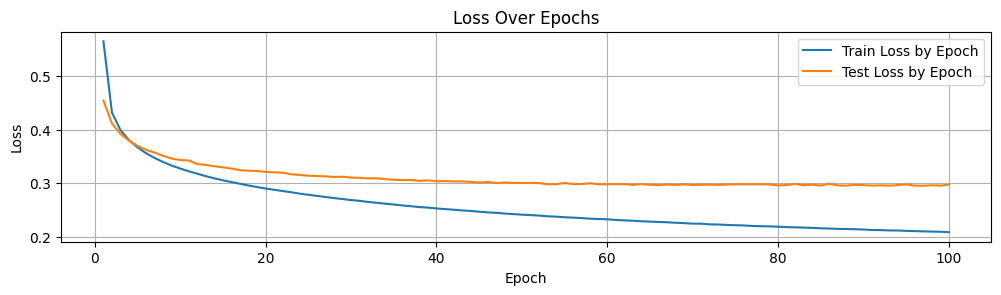

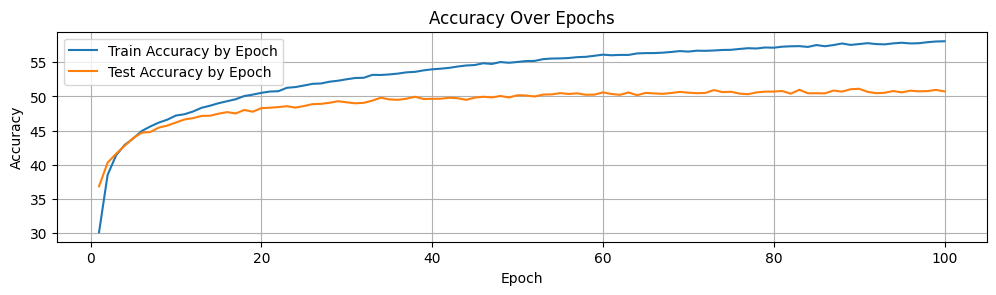

In [704]:
nl=[120,100,10]
 
data_train, label_train = data_train_pca.to(device), label_train_cifar10.to(device).long()
data_test, label_test = data_test_pca.to(device), label_test_cifar10.to(device).long()


nn_m = Neural_Network_General_model(nl,2,[nn.ReLU()]).to(device)

train_test_plot(nn_m,100,0.01,0.8,data_train,label_train,data_test,label_test,100,False)

Τα αποτελέσματα ως προς το Train και Test accuracy είναι παρόμοια με αυτά που εξάγαγαμε λύνωντας τα multiclass SVMs. (πετύχαμε σε αρκετά Training κοντά σε 60% και Test κοντά σε 50%). Αυτή ήταν η υπόθεση που κάναμε και παραπάνω.

Ακολουθεί ακόμα μια δοκιμή κάνοντας την χρήση 

In [751]:
import torch.nn as nn
import torch.optim as optim
class HingeLossNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HingeLossNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # Raw scores (logits) for hinge loss
        return x

# Instantiate model, loss, and optimizer
model = HingeLossNN(120, 1000, 10)
criterion = nn.MultiMarginLoss()  # Hinge loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(torch.tensor(data_train_pca_np,dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(label_train_cifar10_np,dtype=torch.long))  # MultiMarginLoss expects raw scores and class indices
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate model
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(data_test_pca_np,dtype=torch.float32))
    predicted_classes = torch.argmax(predictions, dim=1)
    accuracy = (predicted_classes == torch.tensor(label_test_cifar10_np,dtype=torch.long)).float().mean()
    print(f"Test Accuracy: {accuracy:.2f}")

Epoch [100/1000], Loss: 0.3428
Epoch [200/1000], Loss: 0.3078
Epoch [300/1000], Loss: 0.2866
Epoch [400/1000], Loss: 0.2706
Epoch [500/1000], Loss: 0.2575
Epoch [600/1000], Loss: 0.2461
Epoch [700/1000], Loss: 0.2361
Epoch [800/1000], Loss: 0.2269
Epoch [900/1000], Loss: 0.2186
Epoch [1000/1000], Loss: 0.2107
Test Accuracy: 0.50


# <center>Συμπεράσματα </center>

Στα πλαίσια αυτής της εργασίας μάθαμε πολλά πράγματα για τα support vector machines κυρίως κατά την υλοποίηση τους στην κλαση My_SVM. 

Μετά από πολλές ώρες δοκιμών είδαμε πολλάκις την επιρροή των υπεραπαραμέτρων ως προς την αριθμητική ακρίβεια , την δυνατότητα βελτιστοποίησης του προβλήματος (και μάλιστα )